In [1]:
# Short-term dynamics of Excitation-Inhibition Balance in Hippocampal CA3-CA1 circuit
# Aditya Asopa, Upinder Singh Bhalla, NCBS
# Figure 2

# Imports -----------------------------------------------------------------------------------------------
from   pathlib      import Path
import importlib

import numpy                as np
import matplotlib           as mpl
import matplotlib.pyplot    as plt
import seaborn              as sns
import pandas               as pd

from scipy.stats   import kruskal, wilcoxon, mannwhitneyu, ranksums
from scipy.optimize import curve_fit
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
import statsmodels.formula.api as smf

# from eidynamics     import utils, data_quality_checks, ephys_classes, plot_tools, expt_to_dataframe
# from eidynamics     import pattern_index
# from eidynamics     import abf_to_data
from eidynamics.fit_PSC     import find_sweep_expected
# from Findsim        import tab_presyn_patterns_LR_43
# import parse_data
from eidynamics     import utils, plot_tools
import all_cells
import plotFig2
import stat_annotate

# sns.set_context('paper')
# sns.set_context('paper')
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
plt.rcParams['svg.fonttype'] = 'none'

# make a colour map viridis
viridis = mpl.colormaps["viridis"]
flare   = mpl.colormaps["flare"]
crest   = mpl.colormaps["crest"]
magma   = mpl.colormaps["magma"]
edge    = mpl.colormaps['edge']

color_E = "flare"
color_I = "crest"
color_freq = {1:magma(0.05), 5:magma(0.1), 10:magma(0.2), 20:magma(.4), 30:magma(.5), 40:magma(.6), 50:magma(.7), 100:magma(.9)}
color_squares = color_squares = {1:viridis(0.2), 5:viridis(.4), 7:viridis(.6), 15:viridis(.8), 20:viridis(1.0)}
color_EI = {-70:flare(0), 0:crest(0)}
colors_EI = {-70:flare, 0:crest}

Fs = 2e4
%matplotlib widget
freq_sweep_pulses = np.arange(9)

>> Working on:  C:\Users\adity\OneDrive\NCBS


In [2]:
# load data
figure_raw_material_location = Path(r"paper_figure_matter\\")
paper_figure_export_location = Path(r"paper_figures\\Figure2v3\\")
data_path                    = Path(r"parsed_data\\")

# Load the dataset
freq_sweep_vc_datapath =  Path(r"parsed_data\\all_cells_FreqSweep_VC_long.h5")
freq_sweep_cc_datapath =  Path(r"parsed_data\\all_cells_FreqSweep_CC_long.h5")
# df = pd.read_hdf(freq_sweep_vc_datapath, key='data')
df = pd.read_hdf(freq_sweep_cc_datapath, key='data')

# expanded dataframe (processed dataframe with metadata and analysed params)
expanded_data_path = Path(r"parsed_data\all_cells_FreqSweep_combined_expanded.h5")
expanded_data_path2 =  Path(r"parsed_data\\all_cells_FreqSweep_VC_kernelfit_response_measurements.h5") # this is the one with the kernel fit data
xc_FS_analyseddf = pd.read_hdf( expanded_data_path, key='data')
# vc_FS_analyseddf = pd.read_hdf(expanded_data_path2, key='data')
# check if trialID exists in the columns of vc_FS_analyseddf
print('trialID' in vc_FS_analyseddf.columns)

print(vc_FS_analyseddf.shape)
# add a column of trialID to vc_FS_analyseddf, made by converting columns to strings and concatenating
vc_FS_analyseddf['trialID'] = (vc_FS_analyseddf['cellID'].astype(str)) + '_' + (vc_FS_analyseddf['exptID'].astype(str)) + '_'+ (vc_FS_analyseddf['sweep'].astype(str))
print(vc_FS_analyseddf.shape)

True
(4407, 145)
(4407, 145)


In [2]:
freq_sweep_cc_datapath =  Path(r"parsed_data\\FreqSweep\\all_cells_FreqSweep_CC_long.h5")
df = pd.read_hdf(freq_sweep_cc_datapath, key='data')
expanded_data_path = Path(r"parsed_data\\FreqSweep\\all_cells_FreqSweep_combined_expanded.h5")
xc_FS_analyseddf = pd.read_hdf( expanded_data_path, key='data')
xc_FS_analyseddf['trialID'] = (xc_FS_analyseddf['cellID'].astype(str)) + '_' + (xc_FS_analyseddf['exptID'].astype(str)) + '_'+ (xc_FS_analyseddf['sweep'].astype(str))
print(xc_FS_analyseddf.shape)

(7770, 100)


In [3]:
# data screening based on dataflag_fields
dfslice = df[
            (df['location'] == 'CA1') &
            (df['numSq'].isin([1,5,15])) &
            (df['condition'] == 'Control') &
            (df['ch0_response']==1) &
            (df['intensity'] == 100) &
            (df['pulseWidth'] == 2) &
            (df['IR'] >50) & (df['IR'] < 300) &
            (df['tau'] < 40)&
            (df['ac_noise_power_in_ch0'] < 40) 
            # (df['AP'] == 0) 
            # (df['spike_in_baseline_period'] == 0) 
            # (df['spike_in_stim_period'] == 0) 
            # (df['sweepBaseline'] < -100) 
        ]

print(f"Unique cells in pre-screened data: {df['cellID'].nunique()}")
print(f"Unique sweeps in pre-screened data: {df['trialID'].nunique()}")
print(f"Unique cells in screened data: {dfslice['cellID'].nunique()}")
print(f"Unique sweeps in screened data: {dfslice['trialID'].nunique()}")

# vc_screened_trialIDs = dfslice['trialID'].unique()
cc_screened_trialIDs = dfslice['trialID'].unique()

# df3 = vc_FS_analyseddf[vc_FS_analyseddf['trialID'].isin(vc_screened_trialIDs)]
df3 = xc_FS_analyseddf[xc_FS_analyseddf['trialID'].isin(cc_screened_trialIDs)]

# drop the sweeps that have a NaN in the kernel fit data in column 'valley_0'
# df3 = df3.dropna(subset=['valley_0'])
print('sweeps remaining after dropping NaNs: ', df3.shape[0])

Unique cells in pre-screened data: 30
Unique sweeps in pre-screened data: 4971
Unique cells in screened data: 16
Unique sweeps in screened data: 2476
sweeps remaining after dropping NaNs:  2133


In [4]:
def ax_to_partial_dist_heatmap_ax(pivotdf, fig, ax, barw=0.03, pad=0.01, shrink=0.8, axpanel_label='A', palette='viridis', maxlim=500):
    bboxA = ax.get_position()
    x0,x1 = bboxA.x0,bboxA.x1 
    y0,y1 = bboxA.y0,bboxA.y1 
    w, h  = bboxA.width,bboxA.height

    # remove axis ax
    ax.remove()
    # create  a new axis in the position of ax
    ax =  fig.add_axes([x0, y0, shrink*w, shrink*h])
    axx = fig.add_axes([x0, y0+shrink*h+pad, shrink*w, barw], aspect='auto')
    axy = fig.add_axes([x0+shrink*w+pad, y0, barw, shrink*h], aspect='auto')
    axc = fig.add_axes([x0+shrink*w+barw+2*pad, y0, barw, shrink*h], aspect='auto')
    ax.text( -0.1, 1.1/0.8, axpanel_label, fontsize=16, ha='center', transform=ax.transAxes)

    partial_pulse_wise  = pivotdf.mean(axis=0).values.reshape(1,-1)
    partial_freq_wise   = pivotdf.mean(axis=1).values.reshape(-1,1)
    maxlim              = np.round(np.max(pivotdf.values),2)
    minlim              = np.round(np.min(pivotdf.values),2)
    print(maxlim, minlim)
    ax.imshow(pivotdf, cmap=palette, vmin=minlim, vmax=maxlim, aspect='auto', )
    axx.imshow(partial_pulse_wise, cmap=palette, vmin=minlim, vmax=maxlim, )
    axy.imshow(partial_freq_wise, cmap=palette, vmin=minlim, vmax=maxlim, origin='lower')

    ax.set_xticks(np.arange(9), labels=np.arange(9))
    ax.set_ylim([-0.5,3.5])
    ax.set_yticks([0,1,2,3], labels=[20,30,40,50])
    ax.set_xlabel('Pulse Index',    fontdict={'fontsize':12})
    ax.set_ylabel('Frequency (Hz)', fontdict={'fontsize':12})
    # remove ticks but keep tick labels from axis ax
    # remove spines
    ax.spines['bottom'].set_visible(False)
    ax.spines[  'left'].set_visible(False)
    ax.spines[ 'right'].set_visible(False)
    ax.spines[   'top'].set_visible(False)

    # # make some labels invisible
    axx.xaxis.set_tick_params(labelbottom =False)
    axy.yaxis.set_tick_params(labelleft   =False)

    # # set aspect of ax_histy2 same as axy
    numlevels = 10
    fig.colorbar(ax.get_images()[0], cax=axc, )

    # # remove ticks
    axx.get_xaxis().set_visible(False)
    axx.get_yaxis().set_visible(False)
    axy.get_xaxis().set_visible(False)
    axy.get_yaxis().set_visible(False)

    # # change fontsize to 12 for all the axes
    for ax in [axx, axy, axc]:
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                    ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(12)
    axx.set_aspect('auto')
    axy.set_aspect('auto')

    return ax, axx, axy, axc

# Plot EPSPs as heatmaps
for the pulseIndex and stimFreq dimensions for numSq==5

In [5]:
df3.iloc[0,25:45]

pulseTrainStart                                                   0.5
probePulseStart                                                   0.2
frameChangeTimes                                                 3004
pulseTimes          [4000, 10000, 11000, 12000, 13000, 14000, 1500...
sweepLength                                                       1.0
baselineFlag                                                    False
IRFlag                                                          False
RaFlag                                                          False
spikingFlag                                                     False
ChR2Flag                                                        False
fieldData                                                        True
pc0                                                          2.352962
pc1                                                          2.116944
pc2                                                          4.602119
pc3                 

In [16]:
def plot_response_heatmaps(datadf, feature='PSC', figname_suffix=""):
    # Load the data
    # to_plot = [f'pc{i}' for i in freq_sweep_pulses]
    to_plot = [f'{feature}{i}' for i in freq_sweep_pulses]
    df_melt = pd.melt( datadf, id_vars=['cellID',  'clampPotential','stimFreq','numSq','patternList'], value_vars=to_plot, var_name='pulseIndex', value_name='peak_response',)
    df_melt['pulse'] = df_melt.apply(lambda x: x['pulseIndex'][-1], axis=1)
    df_melt['pulse'] = df_melt['pulse'].astype(int)
    df_melt['numSq'] = df_melt['numSq'].astype(int)
    df_melt['clampPotential'] = df_melt['clampPotential'].astype(int)
    df_melt['stimFreq'] = df_melt['stimFreq'].astype(int)

    # convert patternList to integer
    df_melt['patternList'] = df_melt['patternList'].apply(lambda x: int(x))

    # drop pulseIndex column
    df_melt.drop(columns=['pulseIndex'], inplace=True)
    df_melt['peak_response'] = df_melt['peak_response'].abs()
    print(df_melt.head(5))

    sqs = df_melt['numSq'].unique()
    clamps = df_melt['clampPotential'].unique()

    ##----------------------------------------------------------------------------------------------------------------

    # increase the space between the subplots
    colors_EI = {-70:flare, 0:crest}
    %colors nocolor
    # for cell in df_melt['cellID'].unique():
    screened_cells = df_melt['cellID'].unique()#[1621, 1931, 2941, 6201, 6301, 7492]
    # for cell in screened_cells:
    plt.close('all')
    # A4
    Fig2, ax2 = plt.subplots(len(sqs), len(clamps), figsize=(15,10), sharex=False, sharey=False, )
    # make the ax2 2D array
    ax2 = np.array(ax2).reshape(len(sqs), len(clamps))
    
    Fig2.subplots_adjust(hspace=0.5, wspace=0.5)
    figlabels = [['A', 'B'], ['C', 'D'], ['E', 'F']]
    # PSC heatmaps
    for s,sq in enumerate(sqs):
        for c,clamp in enumerate(clamps):
            # conditions
            numSq, clampPotential = sq, clamp
            # apply condition
            print(s,c,numSq, clampPotential)
            xpscdf = df_melt[ (df_melt['numSq'] == numSq) & (df_melt['clampPotential'] == clampPotential)]
            x = xpscdf.groupby(['pulse', 'stimFreq']).mean().reset_index()
            x_matrix = x.pivot(index='stimFreq', columns='pulse', values='peak_response')
            
            # if x_matrix has shape 0, add nan values as a list of 9 values
            # create a new empty dataframe with rows as frequencies and columns as pulses
            if x_matrix.shape[0] == 0:
                x_matrix = pd.DataFrame(np.nan, index=[20,30,40,50], columns=np.arange(9))
            # if in the x_matrix other frequencies don't exist, add them with nan values
            for freq in [20,30,40,50]:
                if freq not in x_matrix.index:
                    x_matrix.loc[freq] = np.nan

            ax_to_partial_dist_heatmap_ax(x_matrix, Fig2, ax2[s,c], barw=0.03, pad=0.01, shrink=0.8, axpanel_label='', palette=colors_EI[clamp])
            
            ax2[s,c].text(-0.1, 1.1, figlabels[s][c], transform=ax2[s,c].transAxes, size=20, weight='bold')
            # ax2[s,c].set_title(f'Heatmap of {feature} for {numSq} Sq and {clamp} mV')

    # add supertitle on figure
    # Fig2.suptitle(f'Peak response to different frequencies and pulses - Cell {cell}', fontsize=16)
    # save fig
    paper_figure_export_location = Path(r"paper_figures\\Figure2v3\\")
    Fig2.savefig(paper_figure_export_location / f'Fig2_{feature}_heatmap_all_cells_{figname_suffix}.svg', format='svg', dpi=300)
    Fig2.savefig(paper_figure_export_location / f'Fig2_{feature}_heatmap_all_cells_{figname_suffix}.png', format='png', dpi=300)

   cellID  clampPotential  stimFreq  numSq  patternList  peak_response  pulse
0    3131             -70        20      5           48       2.352962      0
1    3131             -70        20      5           49       2.441912      0
2    3131             -70        20      5           47       1.829181      0
3    3131             -70        20      5           46       1.227669      0
4    3131             -70        20      5           50       2.508777      0
0 0 5 -70
11.74 1.5
1 0 15 -70
21.66 6.62
2 0 1 -70
nan nan


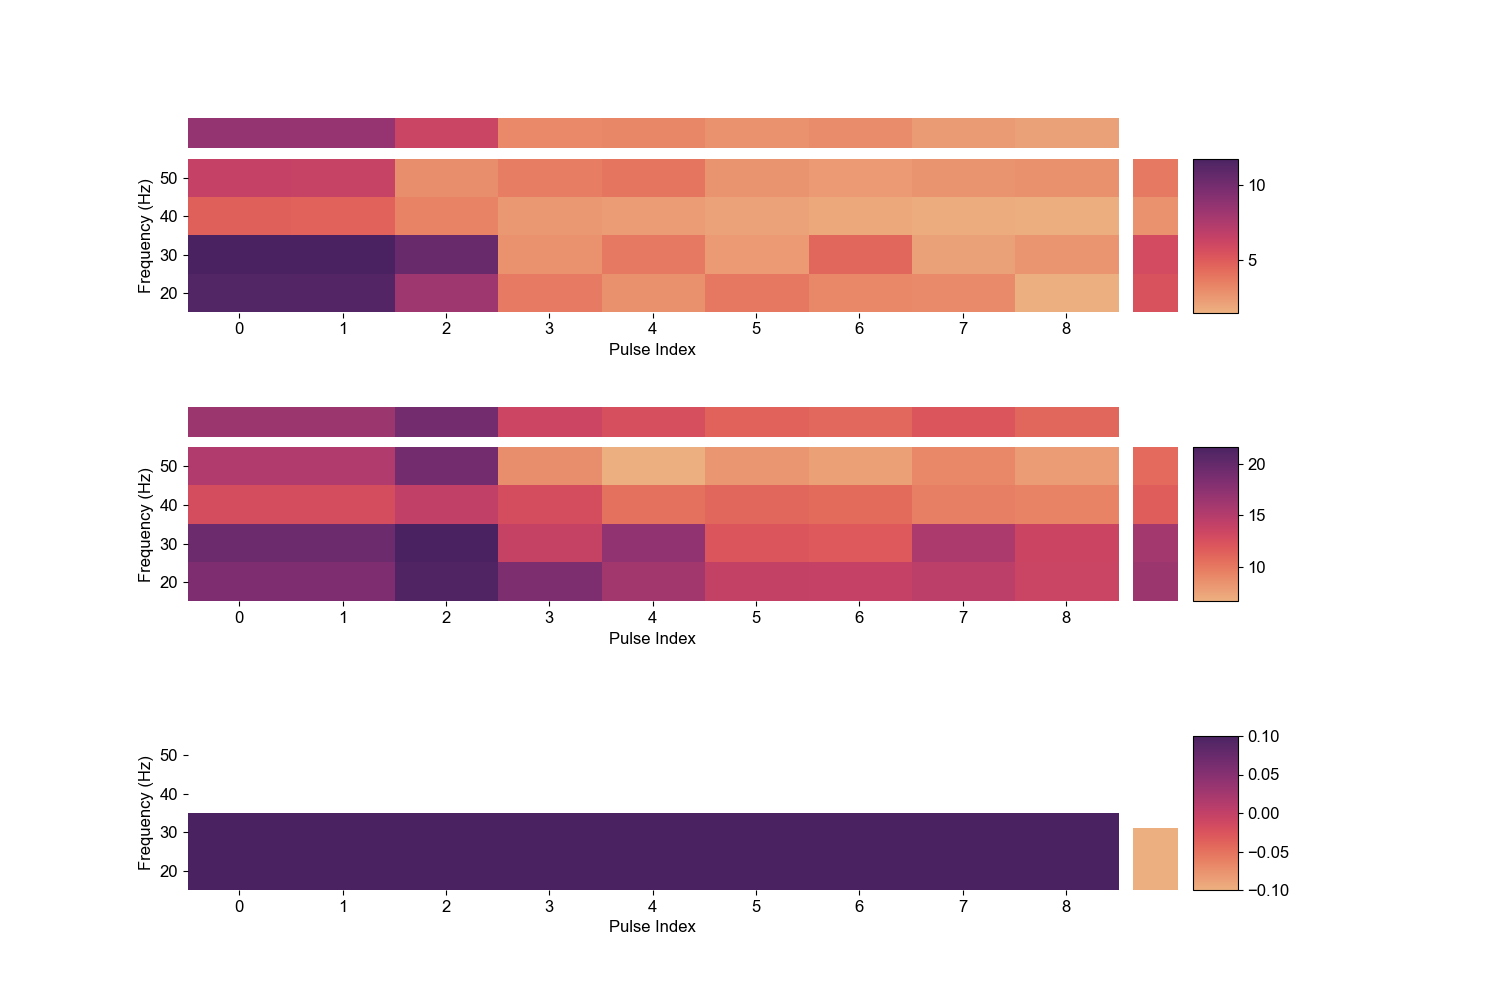

In [17]:
plot_response_heatmaps(df3, feature='pc', figname_suffix="CC")

In [19]:
# save df
df3.to_hdf("screened_cells_CC_for_SVM_fig2.h5", key='data')

C:\Users\adity\AppData\Local\Temp\ipykernel_13980\786219590.py:2: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block4_values] [items->Index(['sex', 'unit', 'location', 'protocol', 'numSq', 'clampMode',
       'clampPotential', 'condition', 'numPatterns', 'patternList',
       'frameChangeTimes', 'pulseTimes', 'fieldData', 'trialID'],
      dtype='object')]

  df3.to_hdf("screened_cells_CC_for_SVM_fig2.h5", key='data')


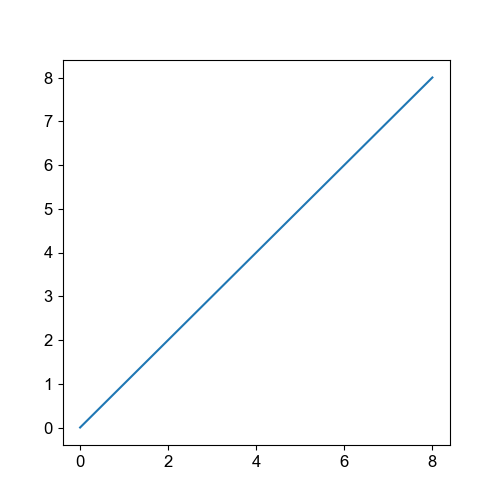

In [20]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
# a test plot
ax.plot(np.arange(9), np.arange(9))

# Plot EPSCs and IPSCs as heatmaps
for the pulseIndex and stimFreq dimensions for numSq==5

In [15]:
df3.sample(5)

,cellID,sex,ageAtInj,ageAtExpt,incubation,unit,location,protocol,exptSeq,exptID,...,normpeak_8,PSC_0,PSC_1,PSC_2,PSC_3,PSC_4,PSC_5,PSC_6,PSC_7,PSC_8
1508,7492,M,29 days,59 days,30 days,pA,CA1,FreqSweep,5,27,...,0.751681,-232.286458,-199.298130,-204.646034,-102.551331,-76.525543,-94.979523,-47.228317,-63.800819,-56.740089
1120,111,F,37 days,94 days,57 days,pA,CA1,FreqSweep,2,5,...,0.852394,20.660939,15.997215,20.969122,9.977431,10.434221,24.255458,20.524409,20.989411,15.644225
357,1541,F,32 days,87 days,55 days,pA,CA1,FreqSweep,2,3,...,0.569247,389.679606,350.003235,312.495123,153.029421,224.106293,158.249887,126.602701,136.160845,239.669403
640,1531,F,32 days,85 days,53 days,pA,CA1,FreqSweep,0,6,...,0.868028,-56.138064,-57.840672,-97.371139,-58.547886,-59.928089,-68.449841,-75.992389,-81.401114,-49.809496
864,1621,M,32 days,72 days,40 days,pA,CA1,FreqSweep,2,10,...,0.112461,-60.430973,-37.173628,-24.903817,-14.849360,-15.219102,-23.698294,-14.812322,-8.311332,-13.273151


In [5]:
def plot_response_heatmaps(datadf, feature='PSC', figname_suffix=""):
    # Load the data
    # to_plot = [f'pc{i}' for i in freq_sweep_pulses]
    to_plot = [f'{feature}_{i}' for i in freq_sweep_pulses]
    df_melt = pd.melt( datadf, id_vars=['cellID',  'clampPotential','stimFreq','numSq','patternList'], value_vars=to_plot, var_name='pulseIndex', value_name='peak_response',)
    df_melt['pulse'] = df_melt.apply(lambda x: x['pulseIndex'][-1], axis=1)
    df_melt['pulse'] = df_melt['pulse'].astype(int)
    df_melt['numSq'] = df_melt['numSq'].astype(int)
    df_melt['clampPotential'] = df_melt['clampPotential'].astype(int)
    df_melt['stimFreq'] = df_melt['stimFreq'].astype(int)

    # convert patternList to integer
    df_melt['patternList'] = df_melt['patternList'].apply(lambda x: int(x))

    # drop pulseIndex column
    df_melt.drop(columns=['pulseIndex'], inplace=True)
    df_melt['peak_response'] = df_melt['peak_response'].abs()
    print(df_melt.head(5))

    ##----------------------------------------------------------------------------------------------------------------

    # increase the space between the subplots
    colors_EI = {-70:flare, 0:crest}
    %colors nocolor
    # for cell in df_melt['cellID'].unique():
    screened_cells = df_melt['cellID'].unique()#[1621, 1931, 2941, 6201, 6301, 7492]
    # for cell in screened_cells:
    plt.close('all')
    # A4
    Fig2, ax2 = plt.subplots(3,2, figsize=(15,10), sharex=False, sharey=False, )
    Fig2.subplots_adjust(hspace=0.5, wspace=0.5)
    figlabels = [['A', 'B'], ['C', 'D'], ['E', 'F']]
    # PSC heatmaps
    for s,sq in enumerate([1,5,15]):
        for c,clamp in enumerate([-70, 0]):
            # conditions
            numSq, clampPotential = sq, clamp
            # apply condition
            xpscdf = df_melt[ (df_melt['numSq'] == numSq) & (df_melt['clampPotential'] == clampPotential)]
            x = xpscdf.groupby(['pulse', 'stimFreq']).mean().reset_index()
            x_matrix = x.pivot(index='stimFreq', columns='pulse', values='peak_response')
            
            # if x_matrix has shape 0, add nan values as a list of 9 values
            # create a new empty dataframe with rows as frequencies and columns as pulses
            if x_matrix.shape[0] == 0:
                x_matrix = pd.DataFrame(np.nan, index=[20,30,40,50], columns=np.arange(9))
            # if in the x_matrix other frequencies don't exist, add them with nan values
            for freq in [20,30,40,50]:
                if freq not in x_matrix.index:
                    x_matrix.loc[freq] = np.nan

            ax_to_partial_dist_heatmap_ax(x_matrix, Fig2, ax2[s,c], barw=0.03, pad=0.01, shrink=0.8, axpanel_label='', palette=colors_EI[clamp])
            
            ax2[s,c].text(-0.1, 1.1, figlabels[s][c], transform=ax2[s,c].transAxes, size=20, weight='bold')

    # add supertitle on figure
    # Fig2.suptitle(f'Peak response to different frequencies and pulses - Cell {cell}', fontsize=16)
    # save fig
    paper_figure_export_location = Path(r"paper_figures\\Figure2v3\\")
    Fig2.savefig(paper_figure_export_location / f'Fig2_{feature}_heatmap_all_cells_{figname_suffix}.svg', format='svg', dpi=300)
    Fig2.savefig(paper_figure_export_location / f'Fig2_{feature}_heatmap_all_cells_{figname_suffix}.png', format='png', dpi=300)

   cellID  clampPotential  stimFreq  numSq  patternList  peak_response  pulse
0    1531             -70        20      5           48        0.21065      0
1    1531             -70        20      5           49        0.20885      0
2    1531             -70        20      5           47        0.21865      0
3    1531             -70        20      5           46        0.20985      0
4    1531             -70        20      5           50        0.21500      0
nan nan
nan nan
0.87 0.22
0.86 0.21
0.86 0.21
0.86 0.21


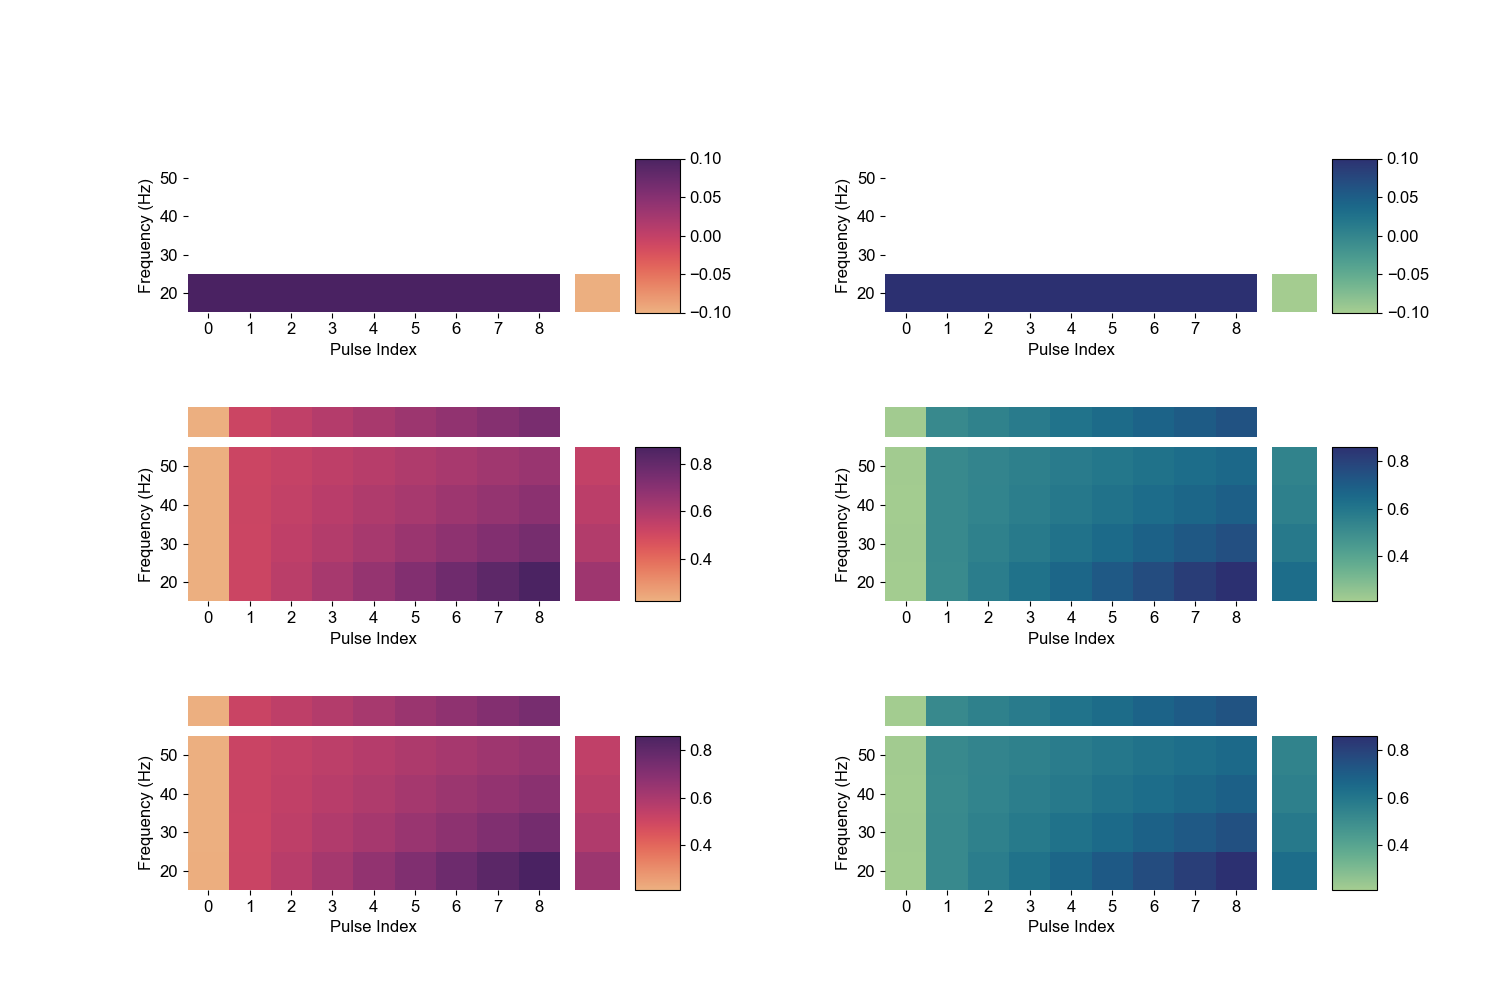

In [17]:
plot_response_heatmaps(df3, feature='peaktime', figname_suffix="")

   cellID  clampPotential  stimFreq  numSq  patternList  peak_response  pulse
0    1531             -70        20      5           48      64.048738      0
1    1531             -70        20      5           49      26.386890      0
2    1531             -70        20      5           47      37.946115      0
3    1531             -70        20      5           46      47.624989      0
4    1531             -70        20      5           50      31.313392      0


<Axes: xlabel='PSC_0', ylabel='Count'>

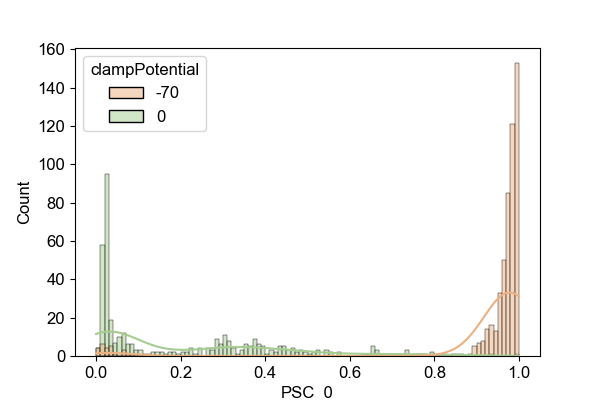

In [27]:
# make histogram of PSC values
to_plot = [f'PSC_{i}' for i in freq_sweep_pulses]
df_melt = pd.melt( df3, id_vars=['cellID',  'clampPotential','stimFreq','numSq','patternList'], value_vars=to_plot, var_name='pulseIndex', value_name='peak_response',)
df_melt['pulse'] = df_melt.apply(lambda x: x['pulseIndex'][-1], axis=1)
df_melt['pulse'] = df_melt['pulse'].astype(int)
df_melt['numSq'] = df_melt['numSq'].astype(int)
df_melt['clampPotential'] = df_melt['clampPotential'].astype(int)
df_melt['stimFreq'] = df_melt['stimFreq'].astype(int)

# convert patternList to integer
df_melt['patternList'] = df_melt['patternList'].apply(lambda x: int(x))

# drop pulseIndex column
df_melt.drop(columns=['pulseIndex'], inplace=True)
df_melt['peak_response'] = df_melt['peak_response'].abs()
print(df_melt.head(5))

# normalize the peak_response in df3 values for each clampPotential group
df3['PSC_0'] = df3.groupby('clampPotential')['PSC_0'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

# pivot back to original form
# df_melt_pivot = df_melt.pivot_table(index=['cellID', 'clampPotential', 'stimFreq', 'numSq', 'patternList'], columns='pulse', values='peak_response').reset_index()
# fig
plt.close('all')
fig, ax = plt.subplots(1,1, figsize=(6,4))
sns.histplot(data=df3, x='PSC_0', hue='clampPotential', bins=100, palette=color_EI, ax=ax, kde=True, common_norm=True)

## ANOVA

### 1.1 ANOVA with raw peak responses with all the pulses

In [20]:
# Load the data
to_plot = [f'PSC_{i}' for i in freq_sweep_pulses] ## VC data
to_plot = [f'pc{i}' for i in freq_sweep_pulses] # CC data
df_melt = pd.melt( df3, id_vars=['cellID',  'clampPotential','stimFreq','numSq','patternList'], value_vars=to_plot, var_name='pulseIndex', value_name='peak_response',)
df_melt['pulse'] = df_melt.apply(lambda x: x['pulseIndex'][-1], axis=1)
df_melt['pulse'] = df_melt['pulse'].astype(int)
df_melt['numSq'] = df_melt['numSq'].astype(int)
df_melt['clampPotential'] = df_melt['clampPotential'].astype(int)
df_melt['stimFreq'] = df_melt['stimFreq'].astype(int)

# convert patternList to integer
df_melt['patternList'] = df_melt['patternList'].apply(lambda x: int(x))

# drop pulseIndex column
df_melt.drop(columns=['pulseIndex'], inplace=True)

print(df_melt.head(5))

   cellID  clampPotential  stimFreq  numSq  patternList  peak_response  pulse
0    3131             -70        20      5           48       2.352962      0
1    3131             -70        20      5           49       2.441912      0
2    3131             -70        20      5           47       1.829181      0
3    3131             -70        20      5           46       1.227669      0
4    3131             -70        20      5           50       2.508777      0


In [22]:
from statsmodels.formula.api import ols

# Fit the ANOVA model
# model = ols('peak_response ~ C(cellID) + numSq + C(clampPotential) + pulse + stimFreq', data=df_melt).fit() # VC data
model = ols('peak_response ~ C(cellID) + numSq + pulse + stimFreq', data=df_melt).fit() # CC data

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                 sum_sq       df            F         PR(>F)
C(cellID)  1.669943e+06     13.0   857.758862   0.000000e+00
numSq      1.984368e+05      1.0  1325.040287  1.347994e-280
pulse      2.598160e+04      1.0   173.489322   1.898534e-39
stimFreq   5.908586e+04      1.0   394.539478   6.358008e-87
Residual   2.872379e+06  19180.0          NaN            NaN


### 1.2 Only pulses that causes highest response in a given trial

In [23]:
# Load the data
to_plot = [f'PSC_{i}' for i in freq_sweep_pulses] # VC data
to_plot = [f'pc{i}' for i in freq_sweep_pulses] # CC data
df_melt = pd.melt( df3, id_vars=['cellID',  'clampPotential','stimFreq','numSq','patternList'], value_vars=to_plot, var_name='pulseIndex', value_name='peak_response',)
df_melt['pulse'] = df_melt.apply(lambda x: x['pulseIndex'][-1], axis=1)
df_melt['pulse'] = df_melt['pulse'].astype(int)
df_melt['numSq'] = df_melt['numSq'].astype(int)
df_melt['clampPotential'] = df_melt['clampPotential'].astype(int)
df_melt['stimFreq'] = df_melt['stimFreq'].astype(int)

# convert patternList to integer
df_melt['patternList'] = df_melt['patternList'].apply(lambda x: int(x))

# drop pulseIndex column
df_melt.drop(columns=['pulseIndex'], inplace=True)
# # # remove all rows with pulse 0
# df_melt = df_melt[df_melt['pulse'] != 0]

# for every cellID, stimFreq, clampPotential, numSq, patternList and pulse, assign a trial
df_melt['trial'] = df_melt.groupby(['cellID', 'stimFreq', 'clampPotential', 'numSq', 'patternList', 'pulse']).cumcount()

# for every cellID, stimFreq, clampPotential, numSq, patternList, and trial combination, find out which pulse has the highest peak_response value
# Group by the specified columns and find the index of the maximum peak_response within each group
idx = df_melt.groupby(['cellID', 'stimFreq', 'clampPotential', 'numSq', 'patternList', 'trial'])['peak_response'].idxmax()

# Use the index to select the corresponding rows
df_max_peak_response = df_melt.loc[idx].reset_index(drop=True)

print(df_max_peak_response.head(5))

   cellID  clampPotential  stimFreq  numSq  patternList  peak_response  pulse  \
0    2501             -70        20      5           46     103.121039      0   
1    2501             -70        20      5           46     102.697378      0   
2    2501             -70        20      5           46     102.606981      0   
3    2501             -70        20      5           47     103.831721      4   
4    2501             -70        20      5           47     102.688331      0   

   trial  
0      0  
1      1  
2      2  
3      0  
4      1  


In [25]:
# now only using pulses that gave max response
from statsmodels.formula.api import ols

# Fit the ANOVA model
# model = ols('peak_response ~ C(cellID) + numSq + C(clampPotential) + pulse + stimFreq', data=df_max_peak_response).fit()
model = ols('peak_response ~ C(cellID) + numSq  + pulse + stimFreq', data=df_max_peak_response).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                  sum_sq      df           F        PR(>F)
C(cellID)  591881.157659    13.0  309.640638  0.000000e+00
numSq       25916.663455     1.0  176.256800  1.073481e-38
pulse           3.015257     1.0    0.020506  8.861452e-01
stimFreq     6609.495089     1.0   44.950557  2.583805e-11
Residual   311135.002569  2116.0         NaN           NaN


### 1.3 Normalized values without patterns identity

In [81]:
# Load the data
to_plot = [f'PSC_{i}' for i in freq_sweep_pulses]
df_melt = pd.melt( df3, id_vars=['cellID', 'stimFreq', 'clampPotential', 'numSq', 'patternList'], value_vars=to_plot, var_name='pulseIndex', value_name='peak_response',)
df_melt['pulse'] = df_melt.apply(lambda x: x['pulseIndex'][-1], axis=1)
df_melt['pulse'] = df_melt['pulse'].astype(int)
df_melt['numSq'] = df_melt['numSq'].astype(int)
df_melt['clampPotential'] = df_melt['clampPotential'].astype(int)
df_melt['stimFreq'] = df_melt['stimFreq'].astype(int)
# convert patternList to integer
df_melt['patternList'] = df_melt['patternList'].apply(lambda x: int(x))
# in clampPotential column, replace -70 with 1 and 0 with 0
df_melt['clampPotential'] = df_melt['clampPotential'].apply(lambda x: 1 if x == -70 else 0)

# drop pulseIndex column
df_melt.drop(columns=['pulseIndex'], inplace=True)
# # remove all rows with pulse 0
df_melt = df_melt[df_melt['pulse'] != 0]

# for every cellID, stimFreq, clampPotential, numSq, patternList and pulse, assign a trial
df_melt['trial'] = df_melt.groupby(['cellID', 'stimFreq', 'clampPotential', 'numSq', 'patternList', 'pulse']).cumcount()

# for every cellID, stimFreq, clampPotential, numSq, patternList, and trial combination, find out which pulse has the highest peak_response value
# Group by the specified columns and find the index of the maximum peak_response within each group
idx = df_melt.groupby(['cellID', 'stimFreq', 'clampPotential', 'numSq', 'patternList', 'trial'])['peak_response'].idxmax()

# Use the index to select the corresponding rows
df_max_peak_response = df_melt.loc[idx].reset_index(drop=True)

print(df_max_peak_response.head(5))

   cellID  stimFreq  clampPotential  numSq  patternList  peak_response  pulse  \
0     111        20               0      1            1     120.858822      8   
1     111        20               0      1            1      39.477328      5   
2     111        20               0      1            1      31.450886      5   
3     111        20               0      1            2      26.760929      1   
4     111        20               0      1            2      22.662542      4   

   trial  
0      0  
1      1  
2      2  
3      0  
4      1  


In [82]:
# Fit the ANOVA model
model2 = ols('peak_response ~ C(cellID) + numSq + C(clampPotential) + pulse + stimFreq', data=df_melt).fit()

# Perform ANOVA
anova_table2 = sm.stats.anova_lm(model2, typ=2)
print(anova_table2)

                         sum_sq      df            F         PR(>F)
C(cellID)          1.162316e+08     5.0   312.021311  3.540087e-304
C(clampPotential)  8.280783e+07     1.0  1111.479715  2.955594e-227
numSq              1.617606e+06     1.0    21.712152   3.222892e-06
pulse              1.183877e+05     1.0     1.589047   2.075019e-01
stimFreq           1.627273e+06     1.0    21.841909   3.012725e-06
Residual           5.541483e+08  7438.0          NaN            NaN


### 1.4 ANOVA on raw values with all treated as categorical variables

In [84]:
# Load the data
to_plot = [f'PSC_{i}' for i in freq_sweep_pulses]
df_melt = pd.melt( df3, id_vars=['cellID',  'clampPotential','stimFreq','numSq','patternList'], value_vars=to_plot, var_name='pulseIndex', value_name='peak_response',)
df_melt['pulse'] = df_melt.apply(lambda x: x['pulseIndex'][-1], axis=1)
df_melt['pulse'] = df_melt['pulse'].astype(int)
df_melt['numSq'] = df_melt['numSq'].astype(int)
df_melt['clampPotential'] = df_melt['clampPotential'].astype(int)
df_melt['stimFreq'] = df_melt['stimFreq'].astype(int)

# convert patternList to integer
df_melt['patternList'] = df_melt['patternList'].apply(lambda x: int(x))

# drop pulseIndex column
df_melt.drop(columns=['pulseIndex'], inplace=True)

print(df_melt.head(5))

from statsmodels.formula.api import ols

# Fit the ANOVA model
model = ols('peak_response ~ C(cellID) + C(numSq) + C(clampPotential) + C(pulse) + C(stimFreq)', data=df_melt).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

   cellID  clampPotential  stimFreq  numSq  patternList  peak_response  pulse
0    1531             -70        20      5           48     -64.048738      0
1    1531             -70        20      5           49     -26.386890      0
2    1531             -70        20      5           47     -37.946115      0
3    1531             -70        20      5           46     -47.624989      0
4    1531             -70        20      5           50     -31.313392      0
                         sum_sq      df            F         PR(>F)
C(cellID)          2.124399e+08     5.0   421.805062   0.000000e+00
C(numSq)           6.908397e+06     2.0    34.292019   1.472074e-15
C(clampPotential)  1.357915e+08     1.0  1348.088878  9.434423e-274
C(pulse)           4.558681e+06     8.0     5.657116   3.445185e-07
C(stimFreq)        4.326234e+06     3.0    14.316425   2.658786e-09
Residual           8.419931e+08  8359.0          NaN            NaN


## 2. Mixed-effects model

### 2.1 with raw values of peak response

In [85]:
# data screening based on dataflag_fields
dfslice = df[
            (df['location'] == 'CA1') &
            (df['numSq'].isin([1,5,15])) &
            (df['condition'] == 'Control') &
            (df['ch0_response']==1) &
            (df['intensity'] == 100) &
            (df['pulseWidth'] == 2) &
            (df['IR'] >50) & (df['IR'] < 300) &
            (df['tau'] < 40)&
            (df['ac_noise_power_in_ch0'] < 40) 
            # (df['AP'] == 0) 
            # (df['spike_in_baseline_period'] == 0) 
            # (df['spike_in_stim_period'] == 0) 
            # (df['sweepBaseline'] < -100) 
        ]

print(f"Unique cells in pre-screened data: {df['cellID'].nunique()}")
print(f"Unique sweeps in pre-screened data: {df['trialID'].nunique()}")
print(f"Unique cells in screened data: {dfslice['cellID'].nunique()}")
print(f"Unique sweeps in screened data: {dfslice['trialID'].nunique()}")

vc_screened_trialIDs = dfslice['trialID'].unique()

# df3 = xc_FS_analyseddf[xc_FS_analyseddf['trialID'].isin(vc_screened_trialIDs)]
df3 = vc_FS_analyseddf[vc_FS_analyseddf['trialID'].isin(vc_screened_trialIDs)]

# drop the sweeps that have a NaN in the kernel fit data in column 'valley_0'
df3 = df3.dropna(subset=['valley_0'])
print('sweeps remaining after dropping NaNs: ', df3.shape[0])

Unique cells in pre-screened data: 19
Unique sweeps in pre-screened data: 4407
Unique cells in screened data: 6
Unique sweeps in screened data: 1201
sweeps remaining after dropping NaNs:  931


In [26]:
# Load the data
to_plot = [f'PSC_{i}' for i in freq_sweep_pulses]
to_plot = [f'pc{i}' for i in freq_sweep_pulses]
df_melt = pd.melt( df3, id_vars=['cellID','clampPotential', 'stimFreq', 'numSq', 'patternList'], value_vars=to_plot, var_name='pulseIndex', value_name='peak_response',)

df_melt['pulse'] = df_melt.apply(lambda x: x['pulseIndex'][-1], axis=1)
df_melt['pulse'] = df_melt['pulse'].astype(int)
df_melt['numSq'] = df_melt['numSq'].astype(int)
df_melt['clampPotential'] = df_melt['clampPotential'].astype(int)
df_melt['stimFreq'] = df_melt['stimFreq'].astype(int)

# convert patternList to integer
df_melt['patternList'] = df_melt['patternList'].apply(lambda x: int(x))

# in clampPotential column, replace -70 with 1 and 0 with 2
# df_melt['clampPotential'] = df_melt['clampPotential'].apply(lambda x: 1 if x == -70 else 2)

# drop pulseIndex column
df_melt.drop(columns=['pulseIndex'], inplace=True)

# remove all rows with pulse 0
# df_melt = df_melt[df_melt['pulse'] != 0]

paper_figures\Figure2v3


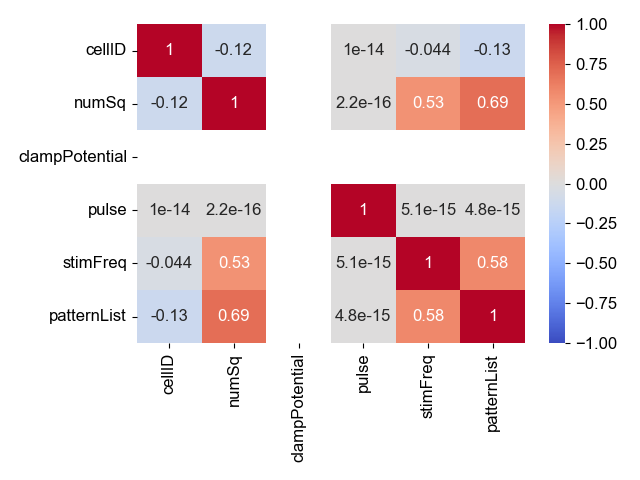

In [28]:
paper_figure_export_location = Path(r"paper_figures\\Figure2v3\\")
corr_matrix = df_melt[['cellID','numSq', 'clampPotential', 'pulse', 'stimFreq','patternList']].corr()
# plot corr matrix
plt.figure(tight_layout=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
print(paper_figure_export_location)
plt.savefig(paper_figure_export_location / 'Fig2_MEM_PSC_corr_matrix_CC.svg', format='svg', dpi=300)
plt.savefig(paper_figure_export_location / 'Fig2_MEM_PSC_corr_matrix_CC.png', format='png', dpi=300)

In [30]:
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

factor_list = ['cellID','stimFreq','numSq','clampPotential','pulse','patternList']
df_melt['replication_group'] = df_melt.groupby(factor_list).cumcount() + 1
print('replicate count:\n', df_melt['replication_group'].value_counts())

# Define the formula for the mixed-effects model (pooled patterns)
formula1 = 'peak_response ~ C(cellID) + (numSq) + (pulse) + (stimFreq) + C(patternList) + C(clampPotential)'
formula2 = "peak_response ~ numSq + stimFreq + C(pulse) + C(clampPotential)" # no interaction between numSq and stimFreq; pulse as categorical and not including patternlist
formula3 = "peak_response ~ numSq + stimFreq + pulse + C(clampPotential) + C(patternList)" # no interaction between numSq, stimFreq and pulse and including patternlist
formula4 = "peak_response ~ numSq * stimFreq * pulse + C(clampPotential) + C(patternList)" # interaction between numSq, stimFreq and pulse and including patternlist
formula5 = "peak_response ~ numSq * stimFreq * pulse + C(clampPotential)" # interaction between numSq, stimFreq and pulse; pulse as categorical and not including patternlist
formula5cc = "peak_response ~ numSq * stimFreq * pulse" # interaction between numSq, stimFreq and pulse; pulse as categorical and not including patternlist

replicate count:
 replication_group
1    6237
2    6102
3    5751
4     405
5     405
6     297
Name: count, dtype: int64


In [31]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

formula_text = "formula5cc"
formula = eval(formula_text)

model = mixedlm(formula, data=df_melt, groups="cellID")
results = model.fit()
print("results summary: \n", results.summary())

# save summary as text file
with open(paper_figure_export_location / f'Fig2_MEModel_summary_{formula_text}.txt', 'w') as fh:
    # add model formula
    fh.write(f"Model formula: {formula}\n\n")
    fh.write(f"\n\n Model Summary: \n\n")
    fh.write(results.summary().as_text())
    fh.write(f"\n\n Model params \n\n")
    fh.write(results.fe_params.to_string())
    fh.write(f"\n\n Model confidence intervals \n\n")
    fh.write(results.conf_int().to_string())

results summary: 
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  peak_response
No. Observations:    19197    Method:              REML         
No. Groups:          14       Scale:               148.8791     
Min. group size:     36       Log-Likelihood:      -75334.8648  
Max. group size:     2844     Converged:           Yes          
Mean group size:     1371.2                                     
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              8.201    3.514  2.334 0.020  1.314 15.089
numSq                  1.019    0.093 10.970 0.000  0.837  1.201
stimFreq              -0.161    0.024 -6.848 0.000 -0.207 -0.115
numSq:stimFreq        -0.001    0.003 -0.288 0.773 -0.007  0.005
pulse                  0.168    0.113  1.486 0.137 -0.053  0.389
numSq:pulse         

## Plotting the results

### 1. Coefficient plot

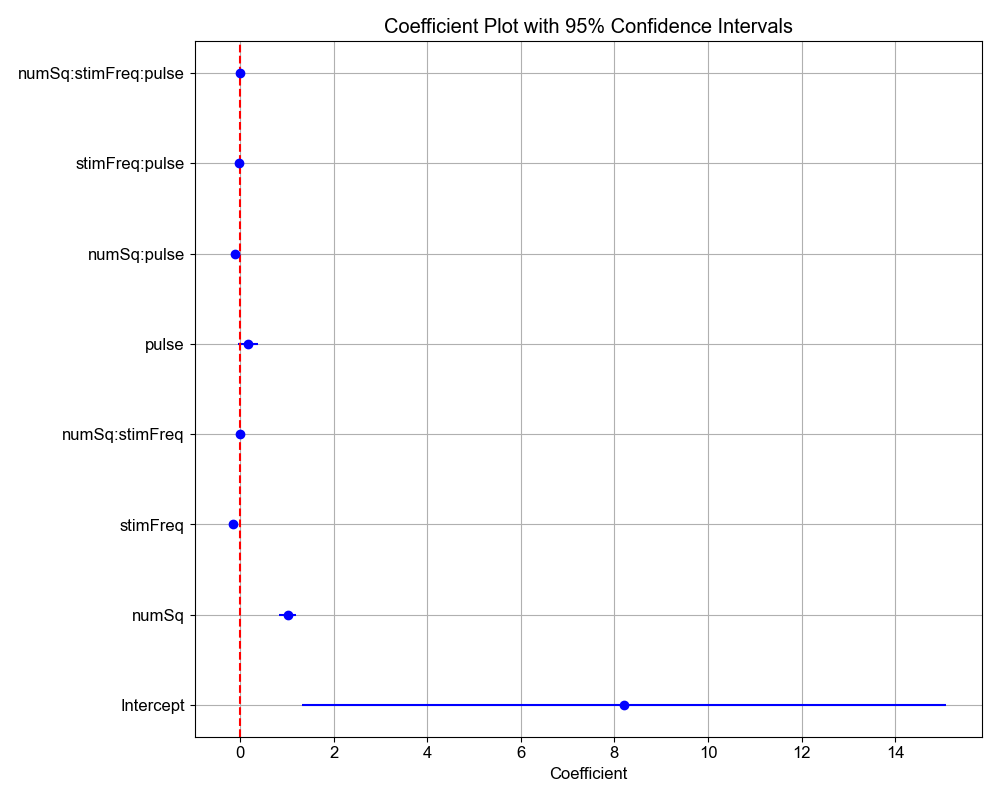

In [32]:
# Extract the fixed effects coefficients and confidence intervals
coefs = results.fe_params
conf = results.conf_int()
# remove the index 'cellID var' from conf
conf = conf.drop(['cellID Var'])

# Create the plot
plt.figure(figsize=(10, 8), layout='tight')
plt.errorbar(coefs, coefs.index, xerr=(conf[1] - coefs), fmt='o', color='blue', label="Coefficients")

# Add a vertical line at zero for reference
plt.axvline(x=0, color='red', linestyle='--')

# Add labels and title
plt.xlabel('Coefficient')
plt.title('Coefficient Plot with 95% Confidence Intervals')
plt.grid(True)
plt.show()

# save fig
plt.savefig(paper_figure_export_location / f'Fig2_coefficient_plot_MEModel_{formula_text}.svg', format='svg', dpi=300)
plt.savefig(paper_figure_export_location / f'Fig2_coefficient_plot_MEModel_{formula_text}.png', format='png', dpi=300)

### 2. Interaction plot

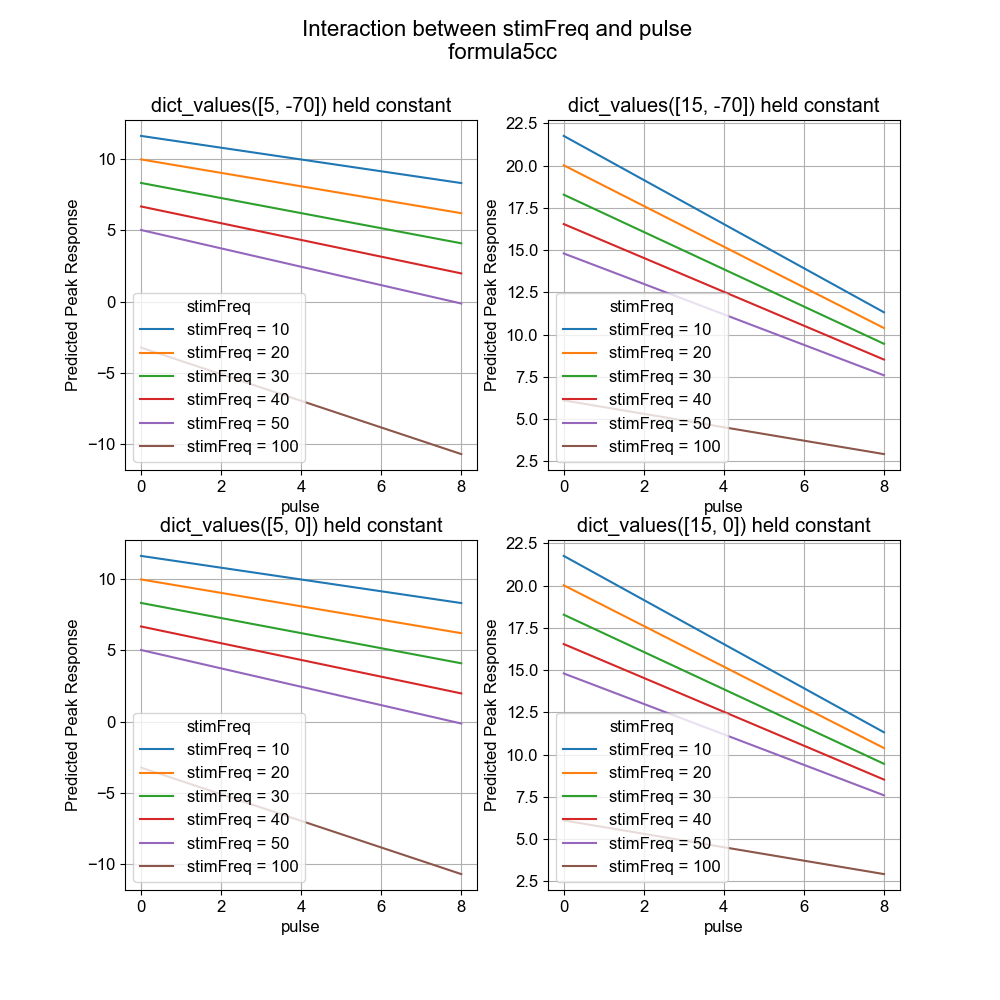

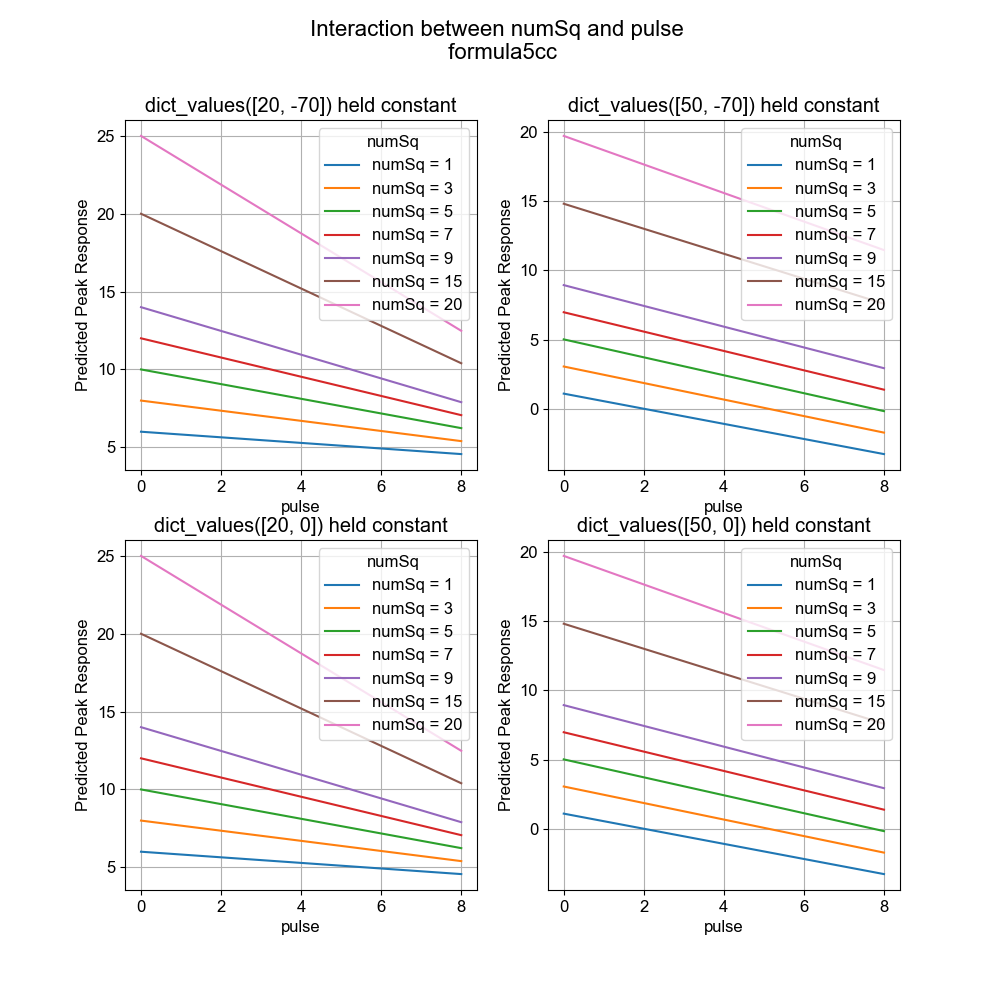

In [33]:
def plot_interaction(var1, var2, var1_values, var2_values, df, model, constant_vars, ax):
    """
    Plots the interaction effect between two variables from the mixed-effects model.

    Parameters:
    - var1: str, the name of the first variable.
    - var2: str, the name of the second variable.
    - var1_values: list, the values of var1 to be tested.
    - var2_values: list, the values of var2 to be tested.
    - df: DataFrame, the original DataFrame containing the data.
    - model: fitted mixed-effects model (results in this case).
    - constant_vars: dict, other variables held constant (e.g., median values).

    Returns:
    - A plot showing the interaction between var1 and var2.
    """

    # Create a list to hold the DataFrames for predictions
    predictions_list = []

    # Generate predictions for each combination of var1 and var2
    for val1 in var1_values:
        df_pred = pd.DataFrame({
            var1: val1,
            var2: var2_values
        })

        # Add other constant variables
        for const_var, const_value in constant_vars.items():
            df_pred[const_var] = const_value
        
        # Add a representative cellID
        df_pred['cellID'] = 2941

        # Generate predictions using the model
        df_pred['predicted_peak_response'] = model.predict(df_pred)
        predictions_list.append(df_pred)

    # Concatenate all predictions into a single DataFrame
    predictions = pd.concat(predictions_list)

    for val1 in var1_values:
        subset = predictions[predictions[var1] == val1]
        ax.plot(subset[var2], subset['predicted_peak_response'], label=f'{var1} = {val1}')

    ax.set_xlabel(var2)
    ax.set_ylabel('Predicted Peak Response')
    ax.set_title(f'{constant_vars.values()} held constant')
    ax.legend(title=var1)
    ax.grid(True)

# make a four subplot figure
fig, ax = plt.subplots(2,2, figsize=(10,10), sharex=False, sharey=False, )
# add fig title
fig.suptitle(f'Interaction between stimFreq and pulse \n {formula_text}', fontsize=16)
ax = ax.ravel()

# Plot interaction between 'stimFreq' and 'pulse'
plot_interaction('stimFreq', 'pulse', [10, 20, 30, 40, 50, 100], [0, 1, 2, 3, 4, 5, 6, 7, 8], df_melt, results, {'numSq':5, 'clampPotential':-70}, ax[0])
# Plot interaction between 'stimFreq' and 'pulse'
plot_interaction('stimFreq', 'pulse', [10, 20, 30, 40, 50, 100], [0, 1, 2, 3, 4, 5, 6, 7, 8], df_melt, results, {'numSq':15, 'clampPotential':-70}, ax[1])
# Plot interaction between 'stimFreq' and 'pulse'
plot_interaction('stimFreq', 'pulse', [10, 20, 30, 40, 50, 100], [0, 1, 2, 3, 4, 5, 6, 7, 8], df_melt, results, {'numSq':5, 'clampPotential':0}, ax[2])
# Plot interaction between 'stimFreq' and 'pulse'
plot_interaction('stimFreq', 'pulse', [10, 20, 30, 40, 50, 100], [0, 1, 2, 3, 4, 5, 6, 7, 8], df_melt, results, {'numSq':15, 'clampPotential':0}, ax[3])

# save fig
plt.savefig(paper_figure_export_location / f'Fig2_interaction_plot_MEModel_{formula_text}_freq_vs_pulse.svg', format='svg', dpi=300)
plt.savefig(paper_figure_export_location / f'Fig2_interaction_plot_MEModel_{formula_text}_freq_vs_pulse.png', format='png', dpi=300)


# make a four subplot figure
fig2, ax2 = plt.subplots(2,2, figsize=(10,10), sharex=False, sharey=False, )
# add fig title
fig2.suptitle(f'Interaction between numSq and pulse \n {formula_text}', fontsize=16)
ax = ax2.ravel()

# Plot interaction between 'stimFreq' and 'pulse'
plot_interaction('numSq', 'pulse', [1,3,5,7,9,15,20], [0, 1, 2, 3, 4, 5, 6, 7, 8], df_melt, results, {'stimFreq':20, 'clampPotential':-70}, ax[0])
# Plot interaction between 'stimFreq' and 'pulse'
plot_interaction('numSq', 'pulse', [1,3,5,7,9,15,20], [0, 1, 2, 3, 4, 5, 6, 7, 8], df_melt, results, {'stimFreq':50, 'clampPotential':-70}, ax[1])
# Plot interaction between 'stimFreq' and 'pulse'
plot_interaction('numSq', 'pulse', [1,3,5,7,9,15,20], [0, 1, 2, 3, 4, 5, 6, 7, 8], df_melt, results, {'stimFreq':20, 'clampPotential':0}, ax[2])
# Plot interaction between 'stimFreq' and 'pulse'
plot_interaction('numSq', 'pulse', [1,3,5,7,9,15,20], [0, 1, 2, 3, 4, 5, 6, 7, 8], df_melt, results, {'stimFreq':50, 'clampPotential':0}, ax[3])
# save fig
plt.savefig(paper_figure_export_location / f'Fig2_interaction_plot_MEModel_{formula_text}_numSq_vs_pulse.svg', format='svg', dpi=300)
plt.savefig(paper_figure_export_location / f'Fig2_interaction_plot_MEModel_{formula_text}_numSq_vs_pulse.png', format='png', dpi=300)

### Effect Plot
An effect plot, also known as a partial dependence plot, shows how the predicted response variable (peak_response) changes as a single predictor variable changes, while holding other variables constant. This type of plot is particularly useful for understanding the marginal effect of a predictor on the response.

Example Code to Generate an Effect Plot
Let’s create an effect plot for one of your variables, say numSq, while holding the other variables constant. We can then do the same for other variables like stimFreq and pulse.

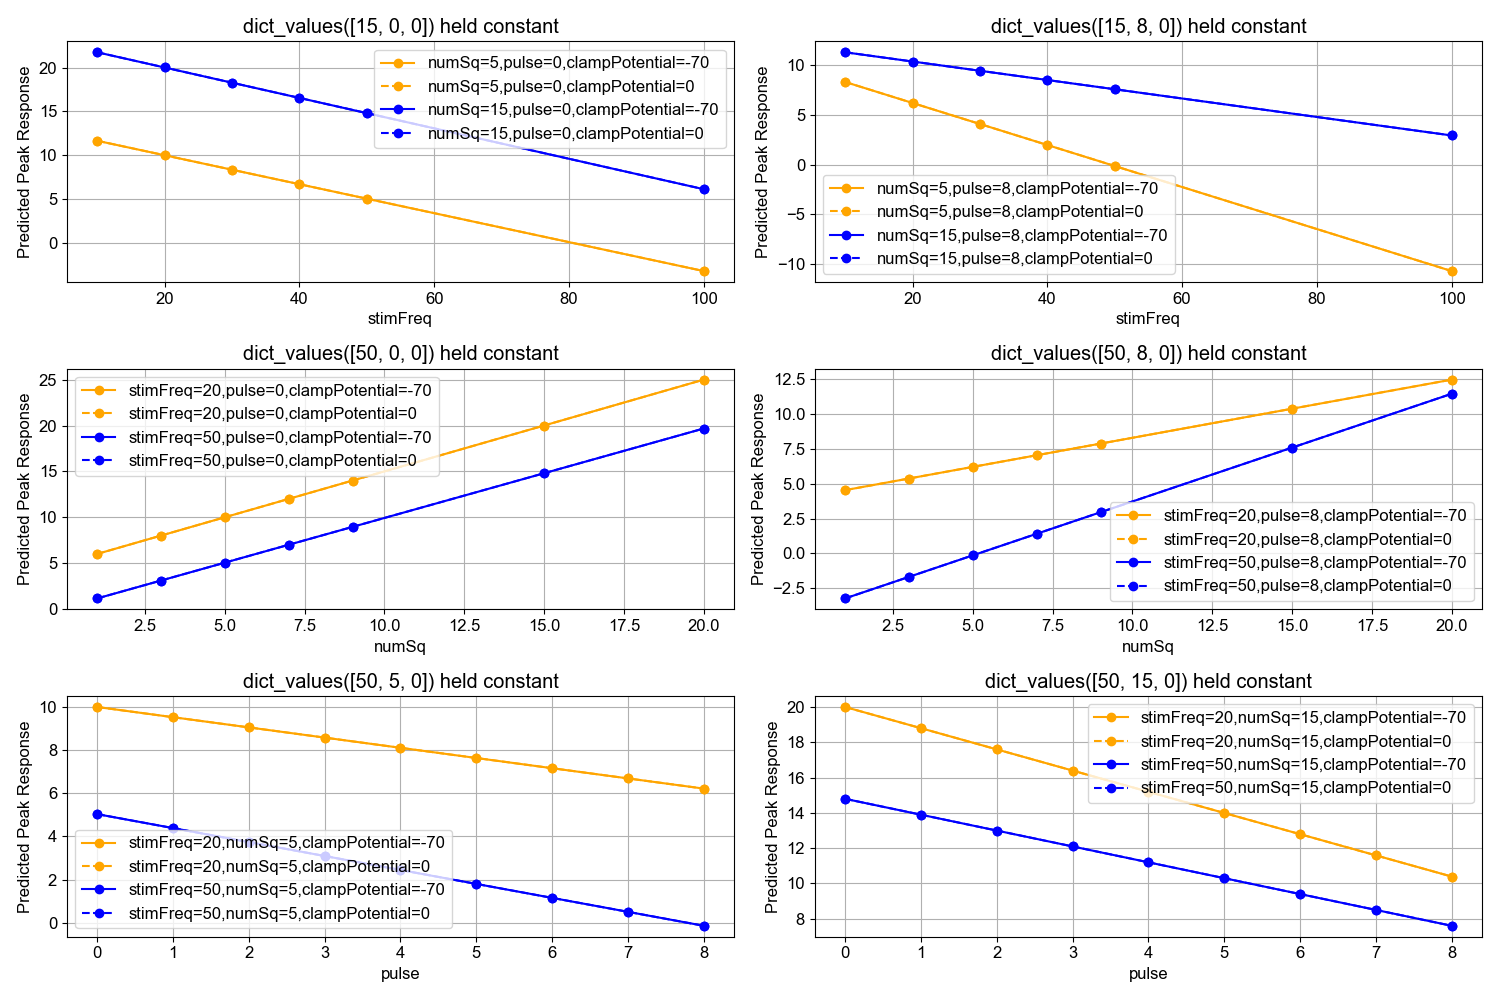

In [34]:
def plot_effect(var, var_values, df, model, constant_vars, ax, label="",lstyle='-', color='blue'):
    """
    Plots the effect of a single variable on the response variable while holding other variables constant.

    Parameters:
    - var: str, the name of the variable.
    - var_values: list, the values of var to be tested.
    - df: DataFrame, the original DataFrame containing the data.
    - model: fitted mixed-effects model (results in this case).
    - constant_vars: dict, other variables held constant (e.g., median values).

    Returns:
    - A plot showing the effect of the variable on the predicted peak response.
    """

    # Create a DataFrame to hold the predictions
    df_pred = pd.DataFrame({var: var_values})

    # Add other constant variables
    for const_var, const_value in constant_vars.items():
        df_pred[const_var] = const_value

    # Add a representative cellID
    df_pred['cellID'] = 2941

    # Generate predictions using the model
    df_pred['predicted_peak_response'] = model.predict(df_pred)
    if label == "":
        # convert dict values into a string
        label = ','.join([f'{key}={value}' for key, value in constant_vars.items()])
    # Plot the effect
    ax.plot(df_pred[var], df_pred['predicted_peak_response'], marker='o', color=color, linestyle=lstyle, label=label)
    ax.set_xlabel(var)
    ax.set_ylabel('Predicted Peak Response')
    ax.set_title(f'{constant_vars.values()} held constant')
    ax.grid(True)
    ax.legend()
    # plt.show()

fig, ax = plt.subplots(3,2, figsize=(15,10), sharex=False, sharey=False, )
ax = ax.ravel()

# Plot the effect of 'stimFreq' on the predicted peak response while varying numSq and clampPotential
plot_effect('stimFreq', [10, 20, 30, 40, 50, 100], df_melt, results, {'numSq':5, 'pulse':0, 'clampPotential':-70}, ax[0], color='orange')
plot_effect('stimFreq', [10, 20, 30, 40, 50, 100], df_melt, results, {'numSq':5, 'pulse':0, 'clampPotential':0}, ax[0],lstyle='--', color='orange')
plot_effect('stimFreq', [10, 20, 30, 40, 50, 100], df_melt, results, {'numSq':15, 'pulse':0, 'clampPotential':-70}, ax[0],)
plot_effect('stimFreq', [10, 20, 30, 40, 50, 100], df_melt, results, {'numSq':15, 'pulse':0, 'clampPotential':0}, ax[0],lstyle='--')

plot_effect('stimFreq', [10, 20, 30, 40, 50, 100], df_melt, results, {'numSq':5, 'pulse':8, 'clampPotential':-70}, ax[1], color='orange')
plot_effect('stimFreq', [10, 20, 30, 40, 50, 100], df_melt, results, {'numSq':5, 'pulse':8, 'clampPotential':0}, ax[1],lstyle='--', color='orange')
plot_effect('stimFreq', [10, 20, 30, 40, 50, 100], df_melt, results, {'numSq':15, 'pulse':8, 'clampPotential':-70}, ax[1],)
plot_effect('stimFreq', [10, 20, 30, 40, 50, 100], df_melt, results, {'numSq':15, 'pulse':8, 'clampPotential':0}, ax[1],lstyle='--')

# Plot the effect of 'numSq' on the predicted peak response while varying stimFreq and clampPotential
plot_effect('numSq', [1,3,5,7,9,15,20], df_melt, results, {'stimFreq':20, 'pulse':0, 'clampPotential':-70}, ax[2], color='orange')
plot_effect('numSq', [1,3,5,7,9,15,20], df_melt, results, {'stimFreq':20, 'pulse':0, 'clampPotential':0}, ax[2],lstyle='--', color='orange')
plot_effect('numSq', [1,3,5,7,9,15,20], df_melt, results, {'stimFreq':50, 'pulse':0, 'clampPotential':-70}, ax[2],)
plot_effect('numSq', [1,3,5,7,9,15,20], df_melt, results, {'stimFreq':50, 'pulse':0, 'clampPotential':0}, ax[2],lstyle='--')

plot_effect('numSq', [1,3,5,7,9,15,20], df_melt, results, {'stimFreq':20, 'pulse':8, 'clampPotential':-70}, ax[3], color='orange')
plot_effect('numSq', [1,3,5,7,9,15,20], df_melt, results, {'stimFreq':20, 'pulse':8, 'clampPotential':0}, ax[3],lstyle='--', color='orange')
plot_effect('numSq', [1,3,5,7,9,15,20], df_melt, results, {'stimFreq':50, 'pulse':8, 'clampPotential':-70}, ax[3],)
plot_effect('numSq', [1,3,5,7,9,15,20], df_melt, results, {'stimFreq':50, 'pulse':8, 'clampPotential':0}, ax[3],lstyle='--')

# Plot the effect of 'pulse' on the predicted peak response while varying stimFreq and clampPotential
plot_effect('pulse', [0, 1, 2, 3, 4, 5, 6, 7, 8], df_melt, results, {'stimFreq':20, 'numSq':5, 'clampPotential':-70}, ax[4], color='orange')
plot_effect('pulse', [0, 1, 2, 3, 4, 5, 6, 7, 8], df_melt, results, {'stimFreq':20, 'numSq':5, 'clampPotential':0}, ax[4],lstyle='--', color='orange')
plot_effect('pulse', [0, 1, 2, 3, 4, 5, 6, 7, 8], df_melt, results, {'stimFreq':50, 'numSq':5, 'clampPotential':-70}, ax[4],)
plot_effect('pulse', [0, 1, 2, 3, 4, 5, 6, 7, 8], df_melt, results, {'stimFreq':50, 'numSq':5, 'clampPotential':0}, ax[4],lstyle='--')

plot_effect('pulse', [0, 1, 2, 3, 4, 5, 6, 7, 8], df_melt, results, {'stimFreq':20, 'numSq':15, 'clampPotential':-70}, ax[5], color='orange')
plot_effect('pulse', [0, 1, 2, 3, 4, 5, 6, 7, 8], df_melt, results, {'stimFreq':20, 'numSq':15, 'clampPotential':0}, ax[5],lstyle='--', color='orange')
plot_effect('pulse', [0, 1, 2, 3, 4, 5, 6, 7, 8], df_melt, results, {'stimFreq':50, 'numSq':15, 'clampPotential':-70}, ax[5],)
plot_effect('pulse', [0, 1, 2, 3, 4, 5, 6, 7, 8], df_melt, results, {'stimFreq':50, 'numSq':15, 'clampPotential':0}, ax[5],lstyle='--')


# layout tight
plt.tight_layout()

# save fig
plt.savefig(paper_figure_export_location / f'Fig2_effect_plot_MEModel_{formula_text}_interaction.svg', format='svg', dpi=300)
plt.savefig(paper_figure_export_location / f'Fig2_effect_plot_MEModel_{formula_text}_interaction.png', format='png', dpi=300)

## Step 4: Marginal Effect Plot
A marginal effect plot shows how the predicted response (peak_response) changes with respect to one variable, averaging out the effects of the other variables. This type of plot is useful for understanding the general trend of a predictor across its range while accounting for the influence of other variables.

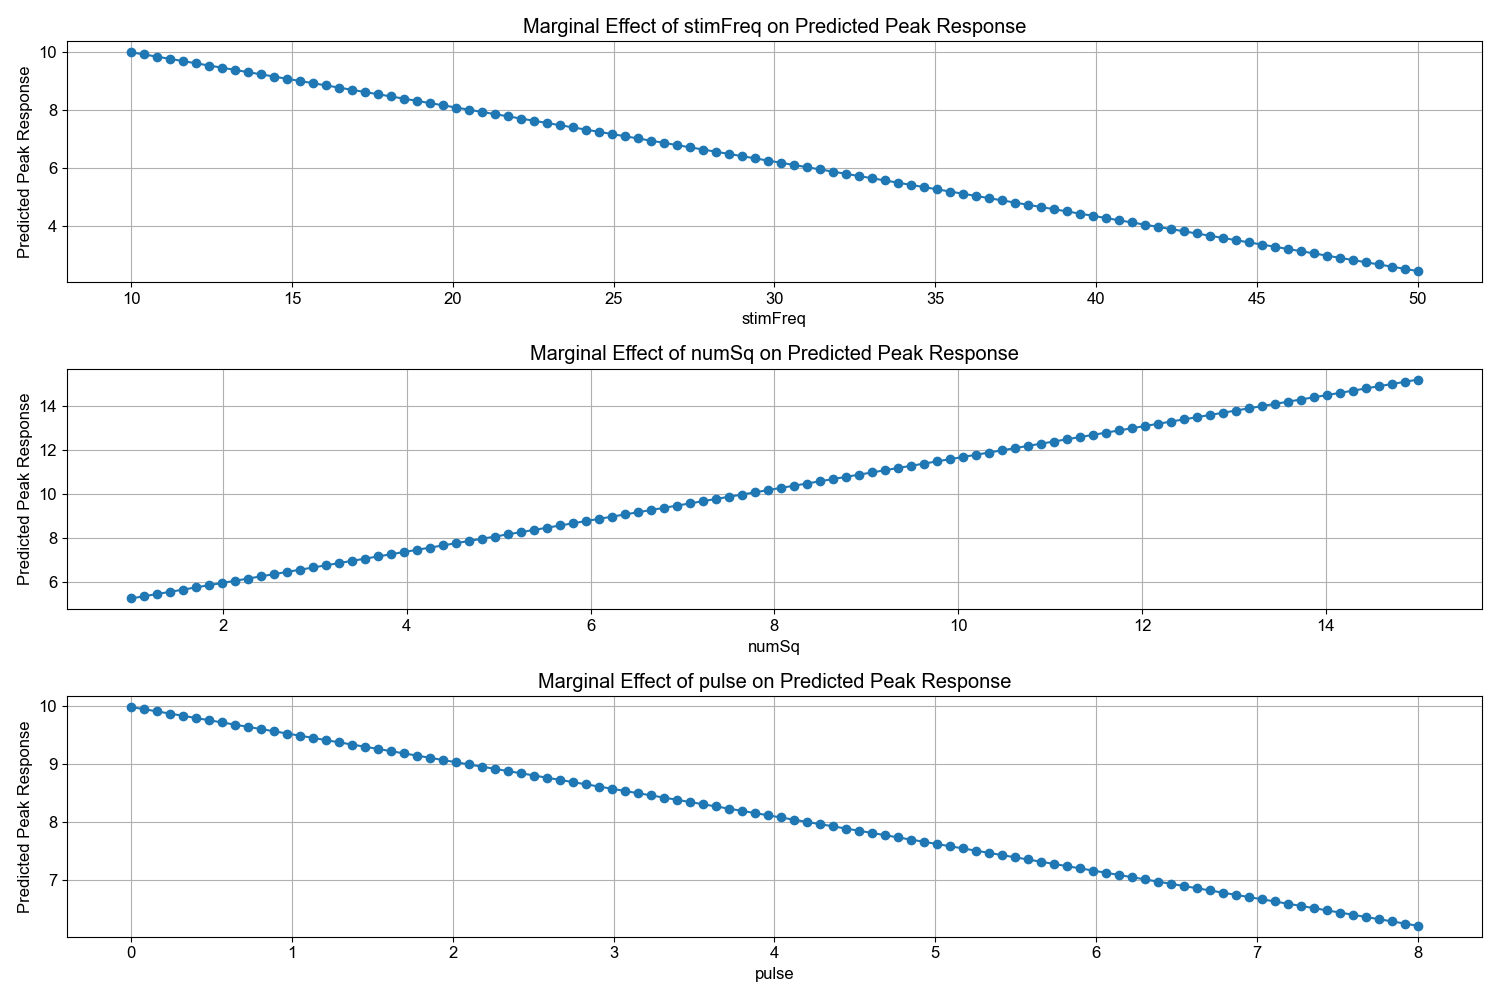

In [35]:
def plot_marginal_effect(var, df, model, ax):
    """
    Plots the marginal effect of a single variable on the response variable.

    Parameters:
    - var: str, the name of the variable.
    - df: DataFrame, the original DataFrame containing the data.
    - model: fitted mixed-effects model (results5 in this case).

    Returns:
    - A plot showing the marginal effect of the variable on the predicted peak response.
    """

    # Create a DataFrame with unique values of the variable
    var_values = np.linspace(df[var].min(), df[var].max(), 100)
    df_pred = pd.DataFrame({var: var_values})

    # For other variables, set them to the median of the data
    for other_var in df.columns:
        if other_var != var and other_var != 'peak_response' and other_var != 'cellID':
            df_pred[other_var] = df[other_var].median()

    # Add a representative cellID
    df_pred['cellID'] = df['cellID'].iloc[0]

    # Generate predictions using the model
    df_pred['predicted_peak_response'] = model.predict(df_pred)

    # Plot the marginal effect
    ax.plot(df_pred[var], df_pred['predicted_peak_response'], marker='o', linestyle='-')
    ax.set_xlabel(var)
    ax.set_ylabel('Predicted Peak Response')
    ax.set_title(f'Marginal Effect of {var} on Predicted Peak Response')
    ax.grid(True)

# plots
fig, ax = plt.subplots(3,1, figsize=(15,10), sharex=False, sharey=False, )

# Plot the marginal effect of 'stimFreq'
plot_marginal_effect('stimFreq', df_melt, results, ax[0])

# Plot the marginal effect of 'numSq'
plot_marginal_effect('numSq', df_melt, results, ax[1])

# Plot the marginal effect of 'pulse'
plot_marginal_effect('pulse', df_melt, results, ax[2])

# layout tight
plt.tight_layout()

# save fig
plt.savefig(paper_figure_export_location / f'Fig2_marginal_effect_plot_MEModel_{formula_text}.svg', format='svg', dpi=300)
plt.savefig(paper_figure_export_location / f'Fig2_marginal_effect_plot_MEModel_{formula_text}.png', format='png', dpi=300)

## 5: Predicted vs. Actual Values Plot
This plot is a key diagnostic tool to evaluate how well your model predicts the actual data. It’s a simple scatter plot where:

The x-axis represents the predicted values (peak_response) from your model.
The y-axis represents the actual observed values.
Purpose of the Plot:
Model Fit: Ideally, the points should cluster around the diagonal line (where predicted = actual). This would indicate a good fit.
Identifying Errors: Deviations from the diagonal can highlight areas where the model may not be fitting the data well.

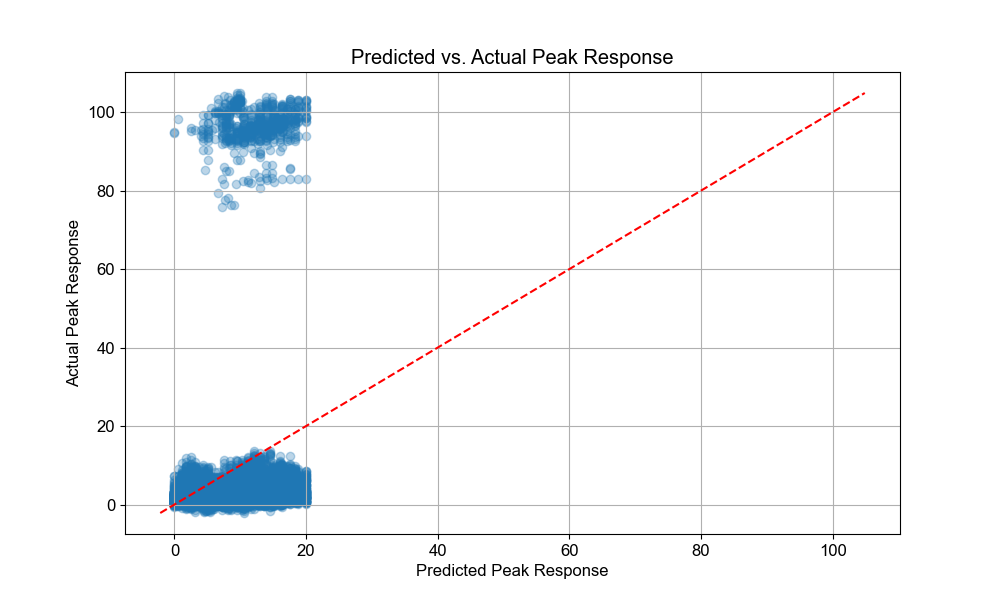

In [36]:
def plot_predicted_vs_actual(df, model):
    """
    Plots predicted vs. actual values for the response variable.

    Parameters:
    - df: DataFrame, the original DataFrame containing the data.
    - model: fitted mixed-effects model (results5 in this case).

    Returns:
    - A scatter plot showing predicted vs. actual values.
    """

    # Generate predicted values using the model
    df['predicted_peak_response'] = model.predict(df)

    # Plot the predicted vs actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(df['predicted_peak_response'], df['peak_response'], alpha=0.3)
    plt.plot([df['peak_response'].min(), df['peak_response'].max()],
             [df['peak_response'].min(), df['peak_response'].max()],
             color='red', linestyle='--')
    plt.xlabel('Predicted Peak Response')
    plt.ylabel('Actual Peak Response')
    plt.title('Predicted vs. Actual Peak Response')
    plt.grid(True)
    plt.show()
    # save fig
    plt.savefig(paper_figure_export_location / f'Fig2_predicted_vs_actual_MEModel_{formula_text}.svg', format='svg', dpi=300)
    plt.savefig(paper_figure_export_location / f'Fig2_predicted_vs_actual_MEModel_{formula_text}.png', format='png', dpi=300)

# Example Usage:
plot_predicted_vs_actual(df_melt, results)

## 3 Random Forest

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# Load the data
to_plot = [f'pc{i}' for i in freq_sweep_pulses]
df_melt = pd.melt( df3, id_vars=['cellID','clampPotential', 'stimFreq', 'numSq', 'patternList'], value_vars=to_plot, var_name='pulseIndex', value_name='peak_response',)

df_melt['pulse'] = df_melt.apply(lambda x: x['pulseIndex'][-1], axis=1)
df_melt['pulse'] = df_melt['pulse'].astype(int)
df_melt['numSq'] = df_melt['numSq'].astype(int)
df_melt['stimFreq'] = df_melt['stimFreq'].astype(int)

# convert patternList to integer
df_melt['patternList'] = df_melt['patternList'].apply(lambda x: int(x))

# in clampPotential column, replace -70 with 1 and 0 with 2
df_melt['clampPotential'] = df_melt['clampPotential'].apply(lambda x: 1 if x == -70 else 0)
df_melt['clampPotential'] = df_melt['clampPotential'].astype(int)

# drop pulseIndex column
df_melt.drop(columns=['pulseIndex'], inplace=True)

# # remove all rows with pulse 0
# df_melt = df_melt[df_melt['pulse'] != 0]

# Define features and target
features = ['numSq', 'stimFreq', 'pulse', 'patternList', 'clampPotential']
target = 'peak_response'
X = df_melt[features]
y = df_melt[target]

# Fit Random Forest model
model = RandomForestRegressor()
model.fit(X, y)

# Get feature importances
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

print(importance_df)


          Feature  Importance
0           numSq    0.136414
1        stimFreq    0.159634
2           pulse    0.250003
3     patternList    0.308050
4  clampPotential    0.145899


# SVM

In [ ]:
from sklearn.svm import SVR
from sklearn.feature_selection import RFE

# Fit SVM model
model = SVR()
model.fit(X, y)

# Use RFE with SVM and specify importance_getter
selector = RFE(model, n_features_to_select=1, importance_getter='auto')
selector = selector.fit(X, y)
# ranking = selector.ranking_

# importance_df = pd.DataFrame({'Feature': features, 'Ranking': ranking})

print(selector)


ValueError: when `importance_getter=='auto'`, the underlying estimator SVR should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

# Load the data
data = df_melt.copy()
# Define features and target
features = ['numSq', 'stimFreq', 'pulse', 'patternList', 'clampPotential']
target = 'peak_response'
X = data[features]
y = data[target]

# Fit Random Forest model
model = RandomForestRegressor()
model.fit(X, y)

# Use RFE with Random Forest
selector = RFE(model, n_features_to_select=1)
selector = selector.fit(X, y)
ranking = selector.ranking_

importance_df = pd.DataFrame({'Feature': features, 'Ranking': ranking})

print(importance_df)



          Feature  Ranking
0           numSq        5
1        stimFreq        3
2           pulse        2
3     patternList        1
4  clampPotential        4


c:\venvs\venv-lab\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
100%|===================| 7536/7542 [03:00<00:00]        

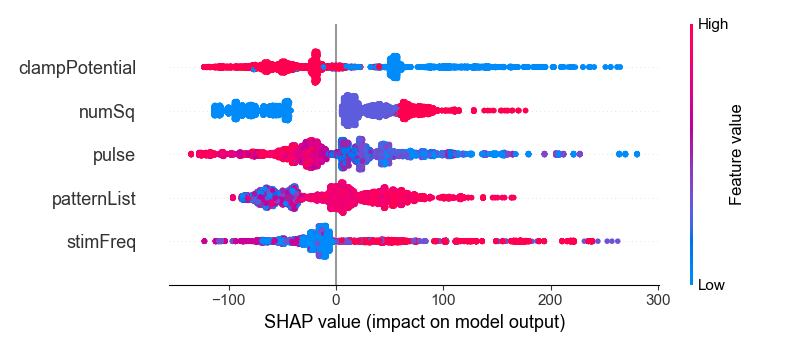

In [ ]:
from sklearn.neural_network import MLPRegressor

# Fit Neural Network model
model = MLPRegressor()
model.fit(X, y)

# Neural Networks do not provide feature importances directly, but you can use techniques like SHAP or LIME for interpretation
# !pip install shap
import shap

# Fit model (using Random Forest as an example)
model = RandomForestRegressor()
model.fit(X, y)

# Create SHAP explainer
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

# Plot SHAP values
plt.figure()
shap.summary_plot(shap_values, X)


## Multivariate ANOVA : Does not apply

In [ ]:
# Assuming your data is in a DataFrame called 'data'
aggregated_data = df_melt.groupby(['cellID', 'numSq', 'clampPotential', 'pulse', 'stimFreq','patternList']).mean().reset_index()


# Define the formula for MANOVA
formula = 'peak_response ~ cellID + numSq + clampPotential + pulse + stimFreq + patternList'

# Fit the model
manova = MANOVA.from_formula(formula, data=aggregated_data)

# Print the results
print(manova.mv_test())



ValueError: There must be more than one dependent variable to fit MANOVA!

[1531 1621  111 7492 6201 6301]
[1531 1621  111 7492 6201 6301]
hue values:  [20 50 30 40]
xtick values:  ['pcn0' 'pcn1' 'pcn2' 'pcn3' 'pcn4' 'pcn5' 'pcn6' 'pcn7' 'pcn8']
4      cellID  stimFreq clampPotential numSq patternList pulseIndex  \
246    1531        20            -70     5          48       pcn1   
247    1531        20            -70     5          49       pcn1   
248    1531        20            -70     5          47       pcn1   
249    1531        20            -70     5          46       pcn1   
261    1531        50            -70     5          48       pcn1   
262    1531        50            -70     5          49       pcn1   
263    1531        50            -70     5          47       pcn1   
264    1531        50            -70     5          46       pcn1   
306    1621        30            -70     5          48       pcn1   
307    1621        30            -70     5          49       pcn1   
308    1621        30            -70     5          47       pcn1   

(0.0, 3.0)

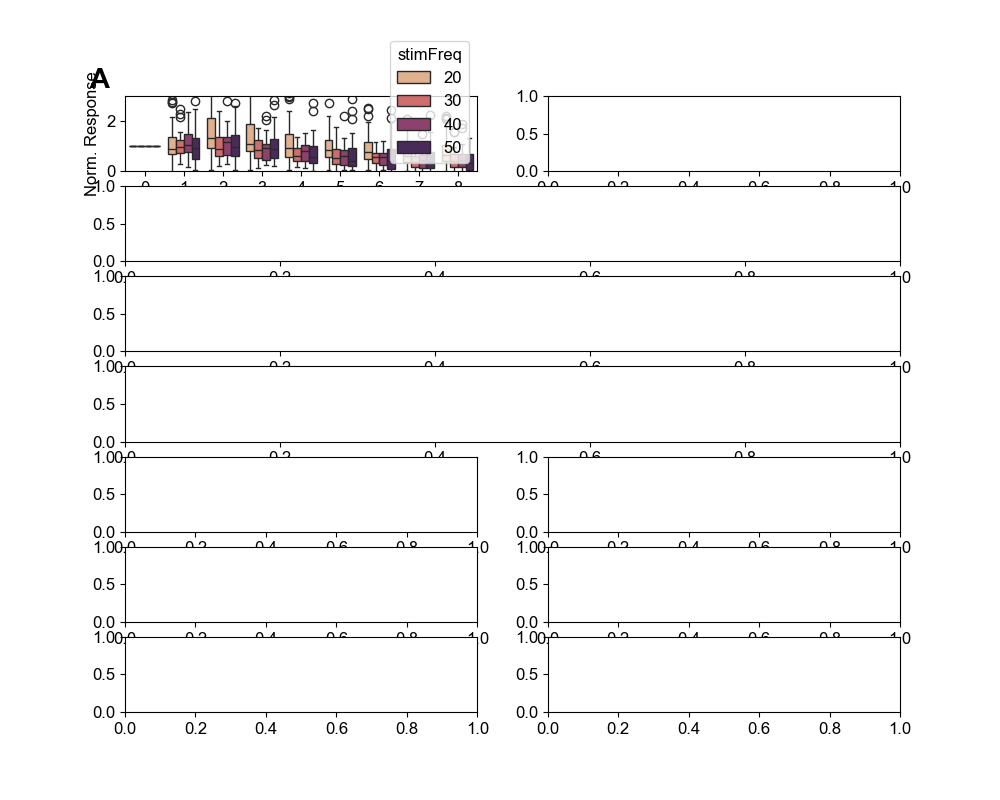

In [ ]:
# Setup the figure
w, h =  10,8
# make a figure of 7 subplots in 2 columns, in which the first subplot spans two columns and first row, and the rest span 1row, 1 column each
Fig2, ax2 = plt.subplot_mosaic([['A', 'B'],['C', 'C'],['D','D'],['E', 'E'],['F', 'G'],['H','I'],['J','K']], figsize=(w, h), )
# change the spacing between plots
# Fig2.subplots_adjust(hspace=1.0, wspace=0.25)
# linearize the ax2 list
ax2 = [ax2[key] for key in ax2.keys()]

# Fig 2A: STP vs numSq for a sample cell, cp = -70mV
plot_kind='strip'
ax2[0].text(-0.1, 1.1, 'A', transform=ax2[0].transAxes, size=20, weight='bold')
# cell =  7492
sq   =  5
cp   = -70        # clamping potential subset for the plot
# f = 20          # stimFreq, Hz

print(df3.cellID.unique())

to_plot = [f'pcn{i}' for i in freq_sweep_pulses]
df_temp = df3[  (df3['numSq'] == sq) & (df3['clampPotential'] == cp)] #
df_melt = pd.melt( df_temp, id_vars=['cellID', 'stimFreq', 'clampPotential', 'numSq', 'patternList'], value_vars=to_plot, var_name='pulseIndex', value_name='peak_response',)

print(df_melt.cellID.unique())
importlib.reload(stat_annotate)

stat_annotate.pairwise_draw_and_annotate_line_plot(   ax2[0], df_melt, x='pulseIndex', y='peak_response', hue='stimFreq', draw=True, kind='box', palette=color_E, 
                                        stat_across='hue', stat=kruskal, skip_first_xvalue=True, annotate_wrt_data=False, offset_btw_star_n_line=0.1, color='grey', coord_system='data', fontsize=12, zorder=10,)
ax2[0].set_xlabel('Pulse Index')
# set xtick location and labels
ax2[0].set_xticks(range(9))
ax2[0].set_xticklabels(freq_sweep_pulses)

# y-axis
ax2[0].set_ylabel('Norm. Response')
ax2[0].set_ylim(0,3)

In [ ]:
# let's do a mulitple comparison test. 
# 1. Let's check if the mean of the peak responses are different for different pulse indices
# 2. Let's check if the standard deviation of the peak responses are different for different pulse indices

# 1. Let's check if the mean of the peak responses are different for different pulse indices
# H0: The mean of the peak responses are the same for all pulse indices
# H1: The mean of the peak responses are different for at least one pulse index
# alpha = 0.05
# One-way ANOVA

# code to do one way anova
from scipy.stats import f_oneway
# get the data
data = df_melt
# get pulse response for each pulse index for numSq==5 and clampPotential==-70, and stimFreq==20. Use pandas groupby
df_temp = data[(data['numSq'] == sq) & (data['clampPotential'] == cp) & (data['stimFreq'] == 20)]




In [ ]:
sq=15
cp=-70
f =20

df_temp = df3[  (df3['numSq'] == sq) & (df3['clampPotential'] == cp)] #
print(df_temp.shape)
df_melt = pd.melt( df_temp, id_vars=['cellID', 'stimFreq', 'clampPotential', 'numSq', 'patternList'], value_vars=to_plot, var_name='pulseIndex', value_name='peak_response',)
df_melt['pulse'] = df_melt.apply(lambda x: x['pulseIndex'][-1], axis=1)
df_melt['pulse'] = df_melt['pulse'].astype(int)
df_melt['numSq'] = df_melt['numSq'].astype(int)
df_melt['clampPotential'] = df_melt['clampPotential'].astype(int)

df_temp = df_melt[(df_melt['numSq'] == sq) & (df_melt['clampPotential'] == cp) & (df_melt['stimFreq'] == f)]
df_temp.groupby('pulse')['peak_response'].mean()

(149, 100)


pulse
0    1.000000
1    0.906342
2    1.249045
3    1.047308
4    1.007266
5    0.995106
6    1.037276
7    0.945204
8    0.935921
Name: peak_response, dtype: float64

In [ ]:
df_melt.columns

Index(['cellID', 'stimFreq', 'clampPotential', 'numSq', 'patternList',
       'pulseIndex', 'peak_response', 'pulse'],
      dtype='object')

### ANOVA to see if peak_response varies

In [ ]:
data

,cellID,stimFreq,clampPotential,numSq,patternList,pulseIndex,peak_response,pulse
246,1531,20,-70,5,48,pcn1,0.691443,1
247,1531,20,-70,5,49,pcn1,3.093787,1
248,1531,20,-70,5,47,pcn1,1.459994,1
249,1531,20,-70,5,46,pcn1,0.821877,1
250,1531,20,-70,5,50,pcn1,0.913949,1
...,...,...,...,...,...,...,...,...
2209,6301,50,-70,5,48,pcn8,0.040688,8
2210,6301,50,-70,5,49,pcn8,0.033109,8
2211,6301,50,-70,5,47,pcn8,0.039827,8
2212,6301,50,-70,5,46,pcn8,0.739795,8


In [ ]:
data = df_melt[df_melt['pulse']!= 0]

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Fit the ANOVA model
model = ols('peak_response ~ C(stimFreq) + C(clampPotential) + C(numSq) + C(patternList) + C(pulse)', data=data).fit()
anova_table = sm.stats.anova_lm()

# Print the ANOVA table
print(anova_table)


IndexError: tuple index out of range

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Example dataset
data = pd.DataFrame({
    'height': [150, 160, 170, 180, 190],
    'weight': [50, 60, 70, 80, 90],
    'gender': ['M', 'F', 'M', 'F', 'M']
})

# Fit the ANOVA model
model = ols('height ~ C(weight) + C(gender)', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Print the ANOVA table
print(anova_table)


c:\venvs\venv-lab\Lib\site-packages\statsmodels\regression\linear_model.py:1718: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


ValueError: r_matrix performs f_test for using dimensions that are asymptotically non-normal

### Trying PCA

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Example dataset
data = pd.DataFrame({
    'height': [150, 160, 170, 180, 190],
    'weight': [50, 60, 70, 80, 90],
    'gender': ['M', 'F', 'M', 'F', 'M']
})

# Convert categorical variable to numeric
data['gender'] = data['gender'].map({'M': 0, 'F': 1})

# Standardize the data
features = ['height', 'weight', 'gender']
x = data.loc[:, features].values
x = StandardScaler().fit_transform(x)

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)
principal_df = pd.DataFrame(data=principal_components, columns=['principal_component_1', 'principal_component_2'])

# Combine with the original data
final_df = pd.concat([principal_df, data[['height', 'weight', 'gender']]], axis=1)
print(final_df)


##
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Example dataset
data = pd.DataFrame({
    'height': [150, 160, 170, 180, 190],
    'weight': [50, 60, 70, 80, 90],
    'gender': ['M', 'F', 'M', 'F', 'M']
})

# Convert categorical variable to numeric
data['gender'] = data['gender'].map({'M': 0, 'F': 1})

# Standardize the data
features = ['height', 'weight', 'gender']
x = data.loc[:, features].values
x = StandardScaler().fit_transform(x)

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)
explained_variance = pca.explained_variance_ratio_

print("Explained variance ratio:", explained_variance)


   principal_component_1  principal_component_2  height  weight  gender
0                   -2.0              -0.816497     150      50       0
1                   -1.0               1.224745     160      60       1
2                    0.0              -0.816497     170      70       0
3                    1.0               1.224745     180      80       1
4                    2.0              -0.816497     190      90       0
Explained variance ratio: [0.66666667 0.33333333]


In [ ]:
data = df_melt[df_melt['pulse']!= 0]

# Standardize the data
features = ['peak_response','stimFreq' ,'clampPotential' ,'numSq' ,'patternList' ,'pulse']
x = data.loc[:, features].values
x = StandardScaler().fit_transform(x)

# Perform PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(x)
principal_df = pd.DataFrame(data=principal_components, columns=['principal_component_1', 'principal_component_2','principal_component_3'])

# Combine with the original data
final_df = pd.concat([principal_df, data[['peak_response','stimFreq' ,'clampPotential' ,'numSq' ,'patternList' ,'pulse']]], axis=1)
print(final_df)


x = data.loc[:, features].values
x = StandardScaler().fit_transform(x)

# Perform PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(x)
explained_variance = pca.explained_variance_ratio_

print("Explained variance ratio:", explained_variance)


      principal_component_1  principal_component_2  principal_component_3  \
0                  0.750043              -1.370851              -0.978289   
1                  0.446197              -1.439721              -1.439675   
2                  1.153816              -1.302198              -0.516671   
3                  1.513259              -1.233449              -0.055156   
4                 -0.002051              -1.508278              -1.901396   
...                     ...                    ...                    ...   
2209                    NaN                    NaN                    NaN   
2210                    NaN                    NaN                    NaN   
2211                    NaN                    NaN                    NaN   
2212                    NaN                    NaN                    NaN   
2213                    NaN                    NaN                    NaN   

      peak_response  stimFreq  clampPotential  numSq  patternList  pulse  


### Random forest

In [ ]:


import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# Example dataset
data = pd.DataFrame({
    'height': [150, 160, 170, 180, 190],
    'weight': [50, 60, 70, 80, 90],
    'gender': ['M', 'F', 'M', 'F', 'M']
})

# Convert categorical variable to numeric
data['gender'] = data['gender'].map({'M': 0, 'F': 1})

# Define features and target
features = ['weight', 'gender']
target = 'height'
X = data[features]
y = data[target]

# Fit Random Forest model
model = RandomForestRegressor()
model.fit(X, y)

# Get feature importances
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

print(importance_df)


  Feature  Importance
0  weight    0.926242
1  gender    0.073758


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

data = df_melt[df_melt['pulse']!= 0]
data = df_melt#[df_melt['pulse']!= 0]

# Standardize the data
features = ['stimFreq' ,'clampPotential' ,'numSq' ,'patternList' ,'pulse']
target = 'peak_response'
X = data[features]
y = data[target]

# Fit Random Forest model
model = RandomForestRegressor()
model.fit(X, y)

# Get feature importances
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

print(importance_df)

          Feature  Importance
0        stimFreq    0.341640
1  clampPotential    0.000000
2           numSq    0.000000
3     patternList    0.135999
4           pulse    0.522361


In [ ]:
# To accommodate repeated observations for the same set of factors in your correlation analysis, you can use the following approaches:

### 1. **Averaging Repeated Observations**
# One way to handle repeated observations is to average them. This approach reduces the data to a single observation per set of factors.

# ```python
import pandas as pd

# Example dataset with repeated observations
data = pd.DataFrame({
    'height': [150, 160, 170, 180, 190, 150, 160, 170, 180, 190],
    'weight': [50, 60, 70, 80, 90, 50, 60, 70, 80, 90],
    'gender': ['M', 'F', 'M', 'F', 'M', 'M', 'F', 'M', 'F', 'M']
})

# Convert categorical variable to numeric
data['gender'] = data['gender'].map({'M': 0, 'F': 1})

# Average repeated observations
data_avg = data.groupby(['weight', 'gender']).mean().reset_index()

# Compute correlation matrix
correlation_matrix = data_avg.corr()

print(correlation_matrix)
# ```

### 2. **Using Mixed-Effects Models**
# If averaging is not suitable, you can use mixed-effects models to account for the repeated measures. This approach is more complex but can handle the repeated observations appropriately.

# ```python
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

# Example dataset with repeated observations
data = pd.DataFrame({
    'height': [150, 160, 170, 180, 190, 150, 160, 170, 180, 190],
    'weight': [50, 60, 70, 80, 90, 50, 60, 70, 80, 90],
    'gender': ['M', 'F', 'M', 'F', 'M', 'M', 'F', 'M', 'F', 'M']
})

# Convert categorical variable to numeric
data['gender'] = data['gender'].map({'M': 0, 'F': 1})

# Fit mixed-effects model
model = mixedlm("height ~ weight + gender", data, groups=data["weight"])
result = model.fit()

print(result.summary())
# ```

### 3. **Using Partial Correlation**
# Partial correlation can help control for the repeated measures by accounting for the influence of other variables.


# These methods should help you handle repeated observations in your correlation analysis. If you have any specific questions or need further assistance, feel free to ask!

        weight  gender  height
weight     1.0     0.0     1.0
gender     0.0     1.0     0.0
height     1.0     0.0     1.0


c:\venvs\venv-lab\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\venvs\venv-lab\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\venvs\venv-lab\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\venvs\venv-lab\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      height  
No. Observations:      10           Method:                  REML    
No. Groups:            5            Scale:                   0.0000  
Min. group size:       2            Log-Likelihood:          209.5961
Max. group size:       2            Converged:               No      
Mean group size:       2.0                                           
---------------------------------------------------------------------
           Coef.  Std.Err.          z           P>|z|  [0.025  0.975]
---------------------------------------------------------------------
Intercept 100.000    0.000 2877362824401208.000 0.000 100.000 100.000
weight      1.000    0.000 2081535523957925.000 0.000   1.000   1.000
gender      0.000    0.000               10.488 0.000   0.000   0.000
Group Var   0.000                                                    



c:\venvs\venv-lab\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\venvs\venv-lab\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
c:\venvs\venv-lab\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 2.576934
  warnings.warn(msg, ConvergenceWarning)
c:\venvs\venv-lab\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
